In [1]:
# import libaries
import geopandas as gpd
import pandas as pd
import json
import numpy as np
from sqlalchemy import create_engine
import time
from datetime import date, timedelta
from rl_v2g import CarsharingEnv
import math

# load the database credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

# create connection string
connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


C:\Users\domin\anaconda3\envs\simulation_car_sharing\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Application of Car-sharing Simulation Environment 

Choose the timespan for the simulation. The simulation will be executed chronologically, starting from the first day (2019-1-1) and continuing for subsequent days (2019-1-2, 2019-1-3, etc.). If a start date other than 2019-1-1 is selected, the "Start simulation" cell below may need to be modified.

In [2]:
# set simulation period
start_date = date(2019, 1, 1)
end_date = date(2019, 1, 5)

# calculate number of days to simulate
nr_iterations = (end_date - start_date).days

# Load data for simulation

### Car-sharing stations

In [3]:
# get station geodata, create spatial index
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
stations.sindex
stations.head()

,station_no,geom
0,2901,POINT (2555501.836 1145060.068)
1,2905,POINT (2752963.411 1260089.916)
2,2910,POINT (2501877.645 1126218.900)
3,2913,POINT (2682234.096 1243208.370)
4,2918,POINT (2736874.744 1253090.505)


### Vehicle information

In [4]:
# get vehicle data
sql = "SELECT * FROM msc_2023_dominik.vehicle_information ORDER BY vehicle_no"
vehicles = pd.read_sql(sql, engine)
vehicles.head()

,index,vehicle_category,vehicle_no,model_name,brand_name,charge_power,battery_capacity,range
0,2962,Minivan,106516,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
1,2963,Minivan,106517,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
2,2964,Minivan,106518,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
3,2965,Minivan,106519,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
4,2966,Combi,106526,Enyaq iV80,Skoda,11.0,82.0,420.0


### Reservations

In [5]:
# get daily reservations, save in dict for fast data access
delta = timedelta(days=1)
reservations_dict = {}
start_date_reservations = start_date
while start_date_reservations <= end_date:
    sql = """SELECT reservation_no, start_station_no, vehicle_no, reservationfrom_time_discrete, drive_firststart_time_discrete, 
            drive_lastend_time_discrete, reservation_duration, revenue_distance, required_soc, revenue_duration, drive_km, 
            (floor(EXTRACT(epoch FROM (date_trunc('hour', TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) + 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes' 
                                - date_trunc('hour', TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) - 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes'
                               )) / 900) * 900 + 900) / 900 AS drive_duration
            FROM msc_2023_dominik.reservations_long_time 
            WHERE  DATE(reservationfrom_discrete_date) = '{}' or  DATE(drive_firststart_discrete_date) = '{}' 
            ORDER BY reservationfrom_discrete""".format(start_date_reservations, start_date_reservations)
    reservations = pd.read_sql(sql, engine)
    reservations_dict[start_date_reservations.strftime('%Y-%m-%d')] = reservations
    start_date_reservations += delta
reservations_dict[(start_date).strftime('%Y-%m-%d')].head()

,reservation_no,start_station_no,vehicle_no,reservationfrom_time_discrete,drive_firststart_time_discrete,drive_lastend_time_discrete,reservation_duration,revenue_distance,required_soc,revenue_duration,drive_km,drive_duration
0,24519192,2886,114874,0.0,0.0,4.0,6.0,10.50,5.384615,5.25,14.0,4.0
1,24519174,1557,115969,0.0,0.0,49.0,50.0,45.75,30.500000,43.75,61.0,50.0
2,24514447,2702,114871,0.0,4.0,5.0,6.0,2.66,1.538462,7.50,4.0,2.0
3,24519221,3165,116525,0.0,0.0,96.0,96.0,0.00,0.000000,0.00,0.0,97.0
4,24519097,4407,113833,0.0,2.0,9.0,10.0,13.00,10.000000,6.25,20.0,7.0


### Electicity prices for charging

In [6]:
# get charging costs data
prices = ""
for i in range(0, 480, 5):
    price = i / 20
    prices += '"Price_chf_kwh_{}", '.format(price)

sql = """SELECT {} "Delivery day" FROM msc_2023_dominik.charging_costs WHERE "Delivery day" >=  '{}' and "Delivery day" <=  '{}' ORDER BY "Delivery day" """.format(prices, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

charging_costs = pd.read_sql(sql, engine)
charging_costs.head()

,Price_chf_kwh_0.0,Price_chf_kwh_0.25,Price_chf_kwh_0.5,Price_chf_kwh_0.75,Price_chf_kwh_1.0,Price_chf_kwh_1.25,Price_chf_kwh_1.5,Price_chf_kwh_1.75,Price_chf_kwh_2.0,Price_chf_kwh_2.25,...,Price_chf_kwh_21.75,Price_chf_kwh_22.0,Price_chf_kwh_22.25,Price_chf_kwh_22.5,Price_chf_kwh_22.75,Price_chf_kwh_23.0,Price_chf_kwh_23.25,Price_chf_kwh_23.5,Price_chf_kwh_23.75,Delivery day
0,0.054160,0.054160,0.054160,0.054160,0.052522,0.052522,0.052522,0.052522,0.050906,0.050906,...,0.054634,0.059397,0.059397,0.059397,0.059397,0.059387,0.059387,0.059387,0.059387,2019-01-01
1,0.053848,0.053848,0.053848,0.053848,0.052436,0.052436,0.052436,0.052436,0.044785,0.044785,...,0.065669,0.064731,0.064731,0.064731,0.064731,0.063546,0.063546,0.063546,0.063546,2019-01-02
2,0.057145,0.057145,0.057145,0.057145,0.054419,0.054419,0.054419,0.054419,0.052070,0.052070,...,0.067910,0.065755,0.065755,0.065755,0.065755,0.061800,0.061800,0.061800,0.061800,2019-01-03
3,0.056671,0.056671,0.056671,0.056671,0.055701,0.055701,0.055701,0.055701,0.053826,0.053826,...,0.069678,0.069764,0.069764,0.069764,0.069764,0.065410,0.065410,0.065410,0.065410,2019-01-04
4,0.067953,0.067953,0.067953,0.067953,0.063018,0.063018,0.063018,0.063018,0.058977,0.058977,...,0.064548,0.065874,0.065874,0.065874,0.065874,0.065863,0.065863,0.065863,0.065863,2019-01-05


In [7]:
# save in dict for fast data access
delta = timedelta(days=1)
charging_costs_dict = {}
start_date_electricity = start_date
while start_date_electricity <= end_date:
    electricity_price_day = charging_costs[charging_costs["Delivery day"].dt.date == start_date_electricity].drop(["Delivery day"],axis = 1).iloc[0].values
    charging_costs_dict[start_date_electricity.strftime('%Y-%m-%d')] = electricity_price_day
    start_date_electricity += delta

### Secondary energy prices (for V2G)

In [8]:
# get v2g price data
sql = """SELECT "Timestamp", "Secondary_positive_v2g_prices_chf_kwh", "Secondary_negative_v2g_prices_chf_kwh" FROM msc_2023_dominik.v2g_prices WHERE "Timestamp" >=  '{}' and "Timestamp" <=  '{}' ORDER BY "Timestamp" """.format(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
v2g_prices = pd.read_sql(sql, engine)
v2g_prices.head()

,Timestamp,Secondary_positive_v2g_prices_chf_kwh,Secondary_negative_v2g_prices_chf_kwh
0,2019-01-01 00:00:00,0.068370,0.045588
1,2019-01-01 00:15:00,0.068838,0.045896
2,2019-01-01 00:30:00,0.068838,0.045896
3,2019-01-01 00:45:00,0.068838,0.045896
4,2019-01-01 01:00:00,0.068838,0.045896


In [9]:
# save in dict for fast data access
delta = timedelta(days=1)
v2g_price_dict = {}
start_date_v2g = start_date
while start_date_v2g <= end_date:
    v2g_price_day_positive = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_positive_v2g_prices_chf_kwh"].values
    v2g_price_day_negative = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_negative_v2g_prices_chf_kwh"].values
    v2g_price_dict[start_date_v2g.strftime('%Y-%m-%d')] = [v2g_price_day_positive, v2g_price_day_negative]
    start_date_v2g += delta

# Create environment

The following code creates the simulation enviroment. The list below descripes all parameters that can be specified. You can experiment and change the default values for costs, penalties, probabilities and time periods of V2G events, etc.

**stations:** Geopandas Geodataframe<br>
*Locations of car-sharing stations, including a distinct "station_no" attribute with station ID.*

**vehicle_information:** Pandas Dataframe<br>
*Includes the features "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category" for each car.*

**soc_initial_low:** float, optional<br>
*Lower bound (0-1) for initial SOC used for the reset of the environment, by default 0.5.*

**doc_initial_high:** float, optional<br>
*Upper bound (0-1) for initial SOC used for the reset of the environment, by default 1.*

**max_charging_power:** int, optional<br>
*Maximum charging power supported by the infrastructure, by default 11kw.*

**episode_len:** int, optional<br>
*Length of one episode in hours, by default 24.*

**dt:** float, optional<br>
*Time step size in hours, by default 0.25 (a quarter hour).*

**cancellation_penalty:** int, optional<br>
*Maximum penalty in CHF for a booking cancelled due to not enough charged battery, by default 100.*

**last_timestep:** int, optional<br>
*Last timestep of simulation, by defualt 55392.*

**random_seed_number:** int, optional<br>
*Used for fixing random components in environment for reproducable results, by default 42.*

**penalty_per_kwh:** int, optional<br>
*Penalty in CHF/kWh for total negative energy difference between beginning and ending of episode, by default 0.25.*

**v2g:** boolean, optional<br>
*Boolean indicating if V2G events take place, by default True.*

**v2g_demand_event_min:** int, optional<br>
*Minimum energy demand during V2G event in kWh per time step (dt), by default 500.*

**v2g_demand_event_max:** int, optional<br>
*Maxiumunm energy demand during V2G event in kwh per time step (dt), by default 500.*

**v2g_max_duration:** int, optional<br>
*Maximum duration of V2G charging or discharging event in hours, by default 3.*

**V2G_penalty:** int, optional<br>
*Penalty in CHF if agent charges/discharges less energy than specified in "v2g_demand_event" during V2G event, by default 10000.*

**v2g_probability_charging_event:** float, optional<br>
*Probability that a charging event will take place around noon, by default 0.5.*

**v2g_probability_discharging_event:** float, optional<br>
*Probability that a discharging event will take place in the morning or evening, by default 0.5.*

**v2g_morning_time_period:** list, optional<br>
*Time period must end before noon. List containing:*
1. first possible time (hours) for starting v2g discharging event in the morning, by default 6.0 (6 AM).
2. last possible time (hours) for starting v2g discharging event in the morning, by default 9.0 (9 AM).
3. last possible timestamp for v2g discharging operation, by default 10.75 (10:45 AM).
                        
**v2g_noon_time_period:** list, optional<br>
*List containing:* 
1. first possible time (hours) for starting v2g charging event at noon, by default 11.0 (11 AM).
2. last possible time (hours) for starting v2g charging event at noon, by default 14.0 (2 PM).
3. last possible timestamp for v2g charging operation, by default 16.0 (4 PM).
                             
**v2g_evening_time_period:** list, optional<br>
*Time period must start after noon. List containing:*
1. first possible time (hours) for starting v2g discharging event in the evening, by default 16.25 (4:15 PM).
2. last possible time (hours) for starting v2g discharging event in the evening, by default 19.0 (7 PM).
3. last possible timestamp for v2g charging operation, by default 24 (00:00 AM, next day).
                             
**planned_bookings:** boolean, optional<br>
*Boolean indicating whether there are planned bookings in the environment; otherwise, all bookings are spontaneous, by default True.*

**precomputed_bookings:** boolean, optional<br>
*Boolean indicating whether the planned bookings in the environment are precomputed (for massive speed up), by default True.*

**max_distance_car_assingment:** int, optional<br>
*Maximum search distance in meter for car-assingment problem, by default 5000.*

**plot_state_histogram:** boolean, optional<br>
*Plot current state of enviorment as histogram or not, by default True.*

**plot_state_animation:** boolean, optional<br>
*Plot current state of enviorment as animation for each car or not, by default True.*

# Implement your charging strategy

In [10]:
def your_v2g_strategy(state, nr_vehicles):
    # state has length of nr_vehicles * 4 + 2
        
    # get current locations of vehicles (station number integer between 1000 and 5000, reservation number integer between 20000000 and 40000000, or -1 if vehicle not aviable/not implemented in system)
    locations_of_vehicles = state[:nr_vehicles]
        
    # get current SOC of vehicles (float between 0 and 1)
    soc_of_vehicles = state[nr_vehicles:nr_vehicles * 2]
    
    # get planned reservations of vehicles, integer between 0 and 55392
    planned_reservations = state[nr_vehicles * 2:nr_vehicles * 3]
    
    # get durations of planned reservations of vehicles, integer between 0 and 55392
    planned_reservations = state[nr_vehicles * 3:nr_vehicles * 4]
        
    # check if V2G event will take place and get demand in the next timestep (0 = no V2G event, positive integer between 500 and 1000 = discharging event, negative integer between 500 and 1000 = charging event)
    v2g_event = state[nr_vehicles * 4:nr_vehicles * 4 + 1]
    
    print("")
    print("event")
    print(v2g_event)
    
    # get current simulation time, integer between 0 and 55392
    current_time = state[nr_vehicles * 4 + 1:]
    
    ## Todo: ##
    # use state together with other information for find your charging strategy for the next timestamp
    # should return numpy array of length nr_vehicles with the action for each vehicle:
    # 0 --> do nothing
    # 1 --> charging
    # 2 --> discharging
    
    
    # dummy examples:
    # charge all vehicles
    action = np.ones(nr_vehicles)
    
    # discharge all vehicles
    #action = np.full(nr_vehicles, 2)
    
    # do nothing
    #action = np.zeros(nr_vehicles)
    
    # send action to enviroment
    return action


# Start long-term simulation

The following code simulates the car-sharing system using your charging strategy over the chosen time period. The following methods of the CarsharingEnv object could be helpful for your specific simulation:
    
### reset(self, daily_data, reservations, electricity_price, timesteps_since_start, v2g_price = None, planned_reservations=None, planned_durations=None):###
Reset environment to beginning of new episode.

***daily_data:*** Pandas DataFrame<br>
*Contains the car trips over the day.*

***reservations:*** Pandas DataFrame<br>
*Includes the features "syscreatedate_time_discrete", "vehicle_no", "reservationfrom_time_discrete", and "reservation_duration" for each reservation.*

***electricity_price:*** Numpy ndarray<br>
*Contains electricity prices for each timestamp.*

***timesteps_since_start:*** int<br>
*Timestamp since start of simulation before current day.*

***v2g_price:*** Numpy ndarray, optional<br>
*Numpy array of legngth self.episode_len containing prices in CHF per kwh, by default None.*

***planned_reservations:*** Pandas DataFrame, optional<br>
*Timestamps of next planned reservations for each car, by default None.*

***planned_durations:*** Pandas DataFrame, optional<br>
*Durations of next planned reservations for each car, by default None.*


### next_day(self, daily_data, reservations, electricity_price, timesteps_since_start, v2g_price = None, planned_reservations=None, planned_durations=None):###
Same input as the reset method, but without reseting the environment. Initializes a new day in the simulation.


### episode_summary_statistics(self, nr_ticks): ###
Plot episode summary statistics.

***nr_ticks:*** int<br>
*Number of xticks in the plot. Usually chosen equal to the number of simulated days.* 


### daily_summary_statistics(self): ###
Plots summary statistics of last simulated day.


Start simulation by running the following cell:

Reset environment to timestamp:  0
Reset environment to timestamp:  0

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event

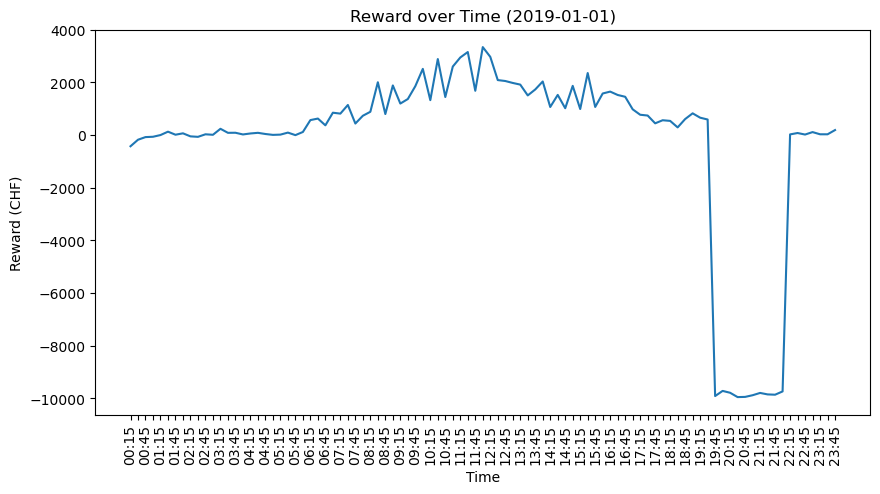

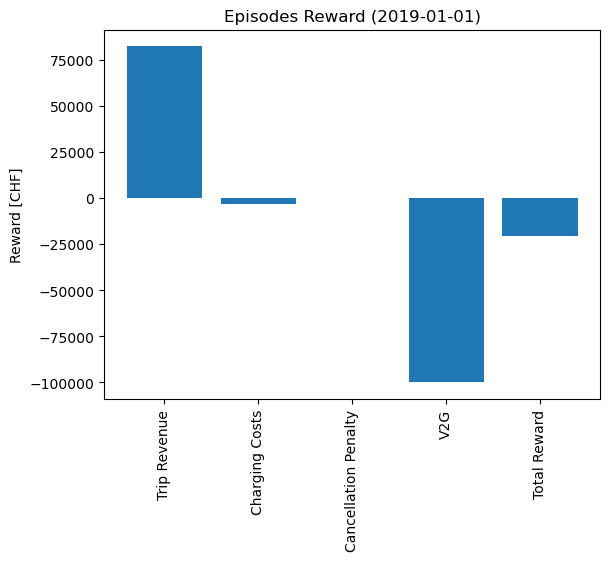

Total reward 2019-01-01:
-20720.28594118382

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[-500.]

event
[-500.]

event
[-500.]

event
[-500.]

event
[-500.]

event
[-500.]

event
[-500.]

event
[-500.]

event
[-500.]

event
[-500.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[500.]

event
[500.]

event
[500.]

event
[500.]

event
[500.]

event
[500.]

event
[500.]


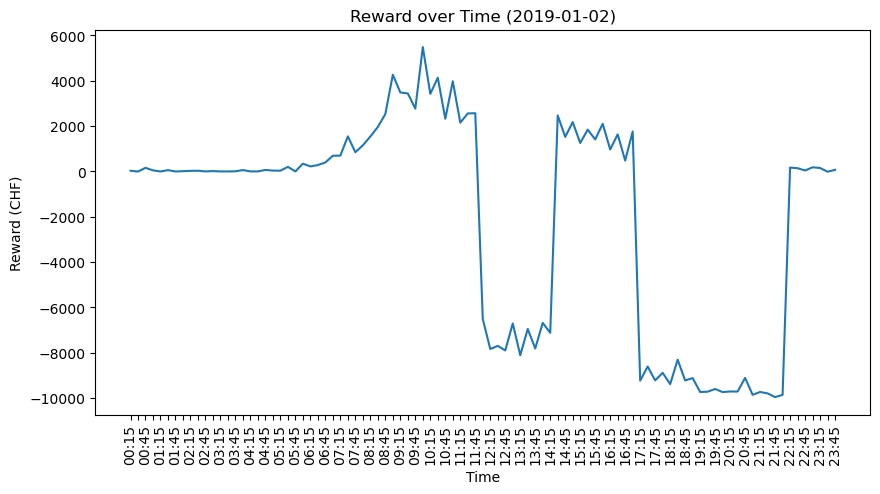

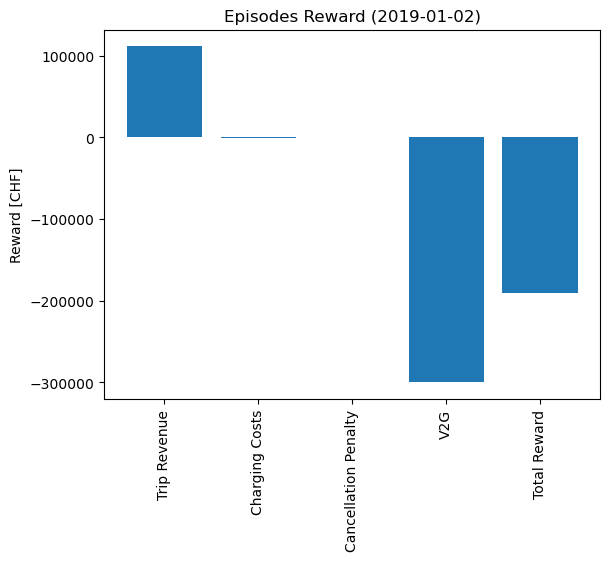

Total reward 2019-01-02:
-189999.32470118193

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[500.]

even

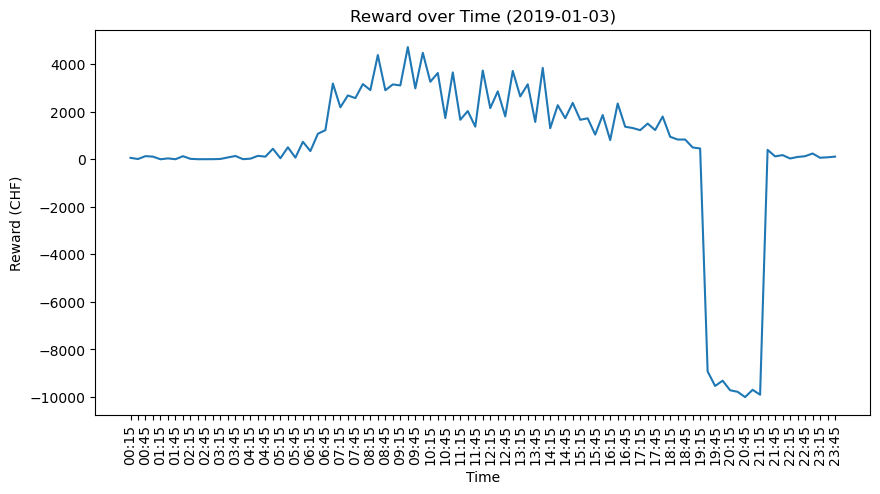

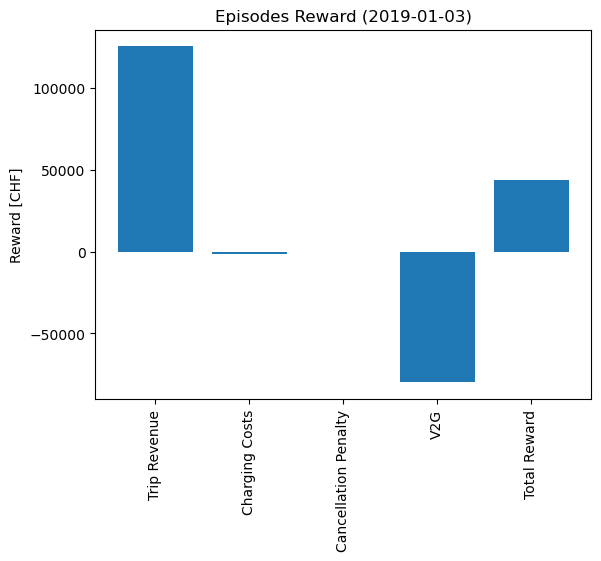

Total reward 2019-01-03:
43857.25851605

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[0.]

event
[500.

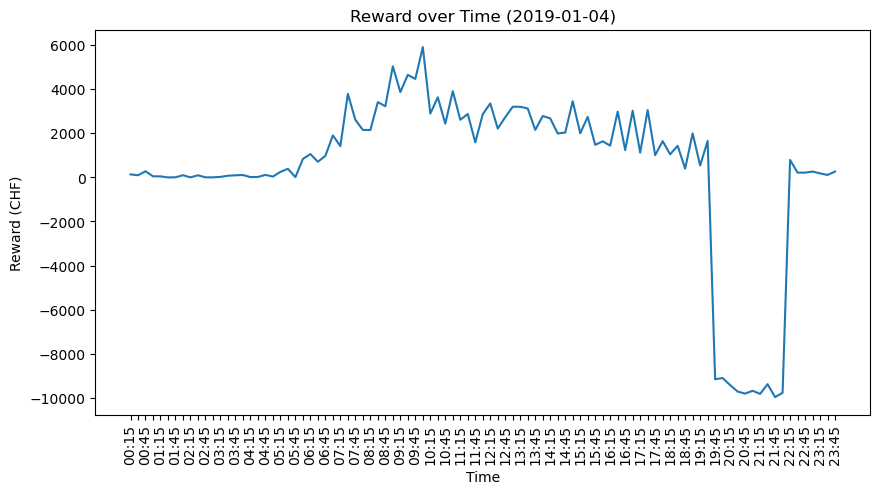

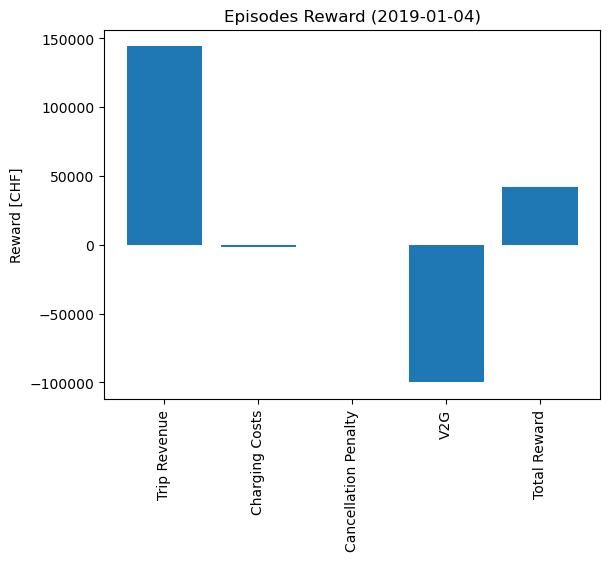

Total reward 2019-01-04:
42057.44981727169


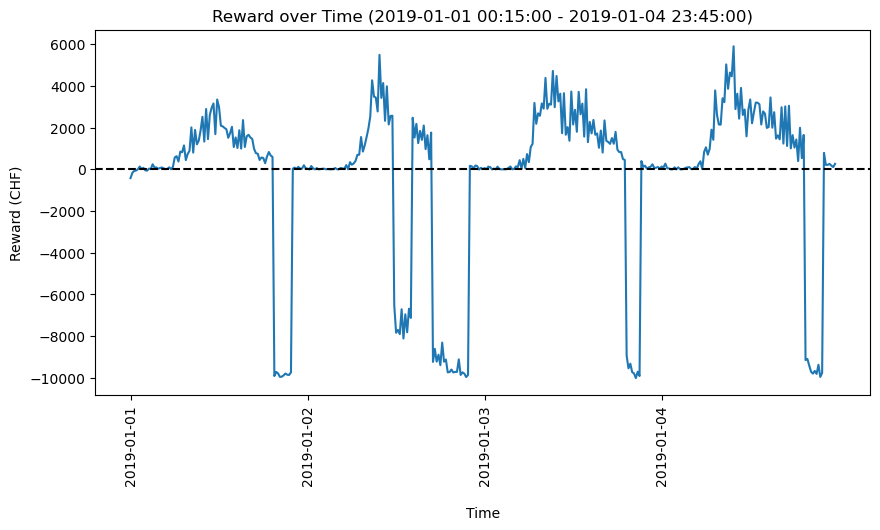

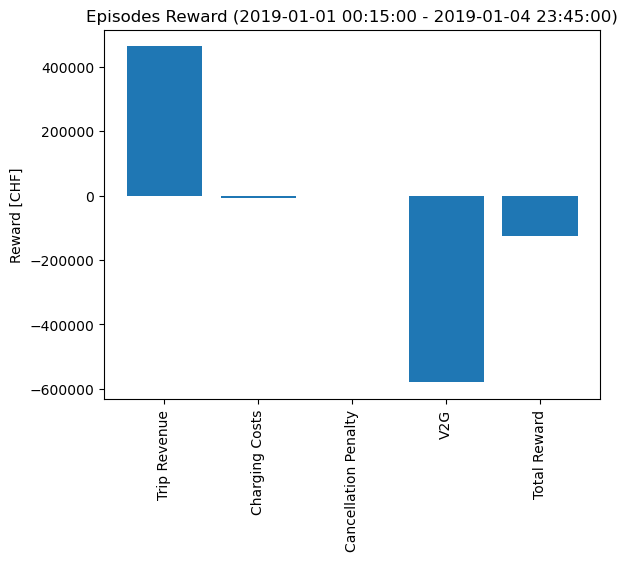

Total reward (2019-01-01 00:15:00 - 2019-01-04 23:45:00):
-124705.4821174345


In [11]:
# get number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0
# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)
    
    # load discrete planned reservation table
    sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_reservations = pd.read_sql(sql, engine)
    
    # load discrete planned reservation duration table
    sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_durations = pd.read_sql(sql, engine)
        
    # iteration for each day
    for day in range(98,676,96):
        
        # calculate number of timesteps since first day of simulation
        timesteps_since_start = count * 96
        
        # measure calculation time of episode
        start = time.time()
        
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        date_day_string = date_day.strftime('%Y-%m-%d')
        
        # load reservations
        reservations = reservations_dict[date_day_string]
        
        # load electricity prices for charging
        electricity_price = charging_costs_dict[date_day_string]
        
        # load secondary energy prices for v2g
        v2g_price = v2g_price_dict[date_day_string]
    
        # select discrete data of day
        daily_data = data.iloc[:,day-97:day-1]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 
        
        # reset environment at beginnning of simulation
        if count == 0:
            env = CarsharingEnv(stations, vehicles, planned_bookings = True, v2g_penalty = 10000, penalty_per_kwh = 0,
                               daily_data = daily_data, reservations = reservations, electricity_price = electricity_price,
                                timesteps_since_start = timesteps_since_start, v2g_price = v2g_price, planned_reservations = planned_reservations_day, 
                                planned_durations = planned_durations_day)
            s = env.reset()
            
        # beginn new day without reseting environemnt 
        else:
            env.next_day(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)
            
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            
            # get your action 
            act = your_v2g_strategy(s, nr_vehicles)

            # proceed one time step
            s, rew, done, _ = env.step(act)
            
            # print reward at time step
            #print("Reward in this step:", rew, " time: ", env.t)
            
            counter +=1
        
        # measure time needed for simulation of day
        end = time.time()
        print("")
        print("Total Episode Time: ", end-start)
        print("")
        
        # plot summary statistics of episode (day)
        env.daily_summary_statistics()
        
        # plot summary statistic over full simulation period
        if count == nr_iterations - 1:
            env.episode_summary_statistics(nr_iterations)
        
        # count number of simulated days
        count += 1

# Animation of simulaton

We can set the parameter ***plot_state_animation = True*** for getting an animation of the vehicels state at each timestep. Each pixel represents one vehicle of the car-sharing system. On a color scale blue-yellow, we can read the current SOC of each car. Grey vehicles are currently not available in the system (not yet implemented or other reasons). Red pixels refer to cars that are currently serving a booking.

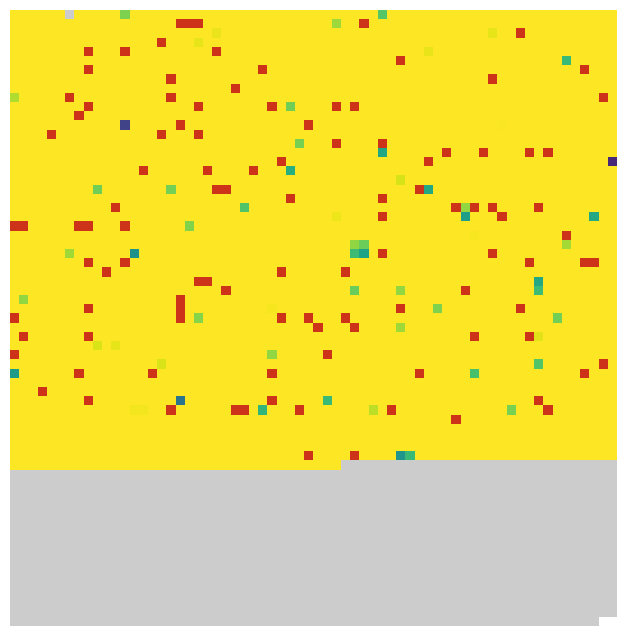

Reward in this step: 191.96936193322975  time:  95

Total Episode Time:  31.354878187179565



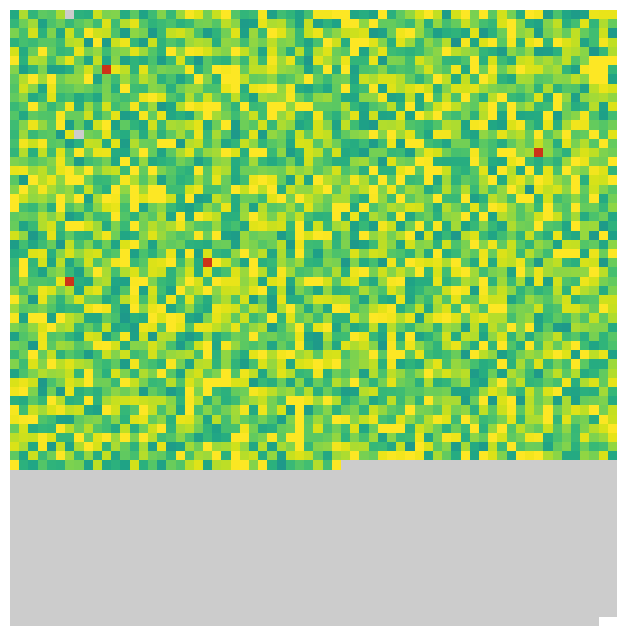

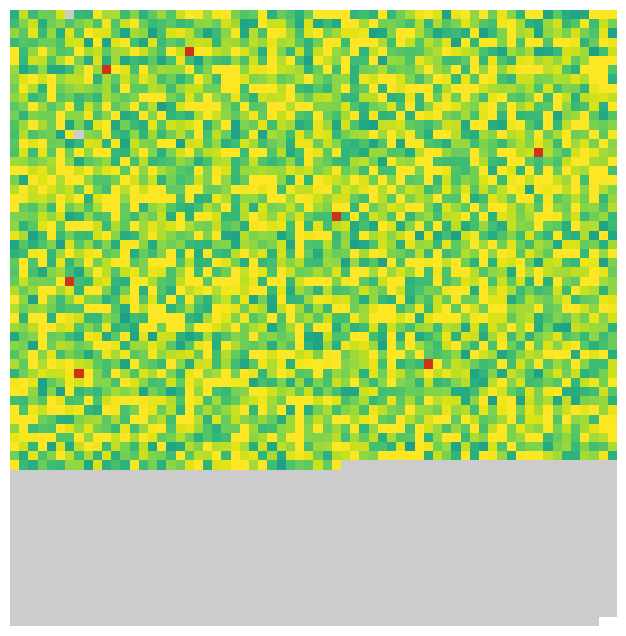

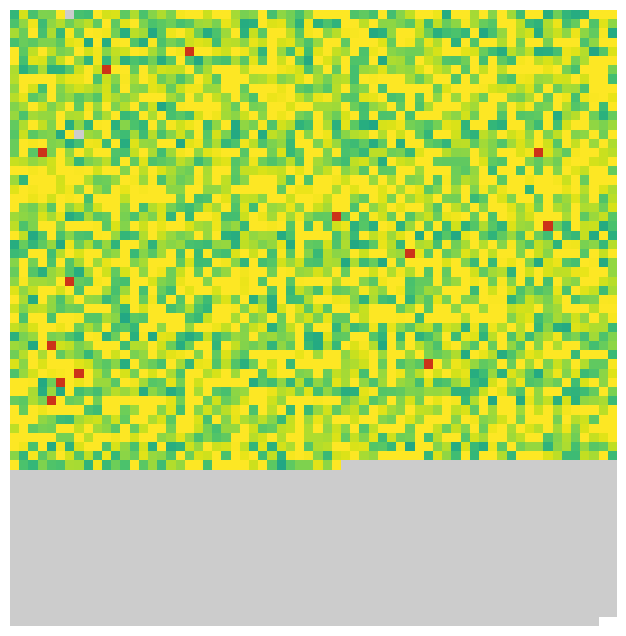

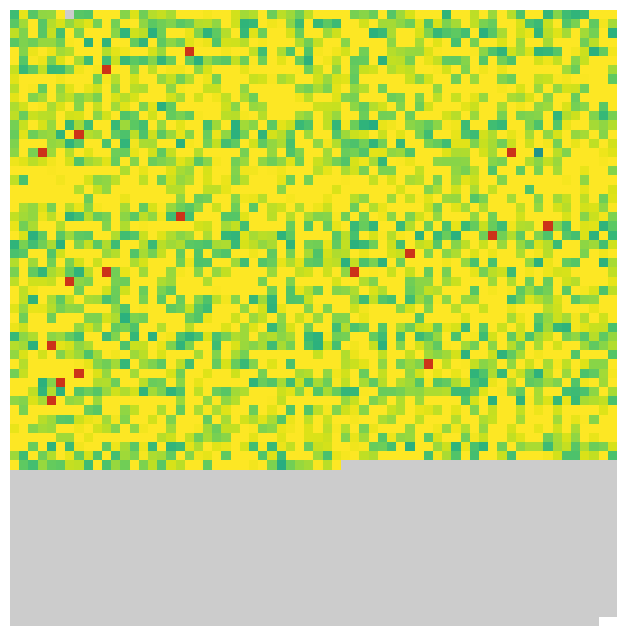

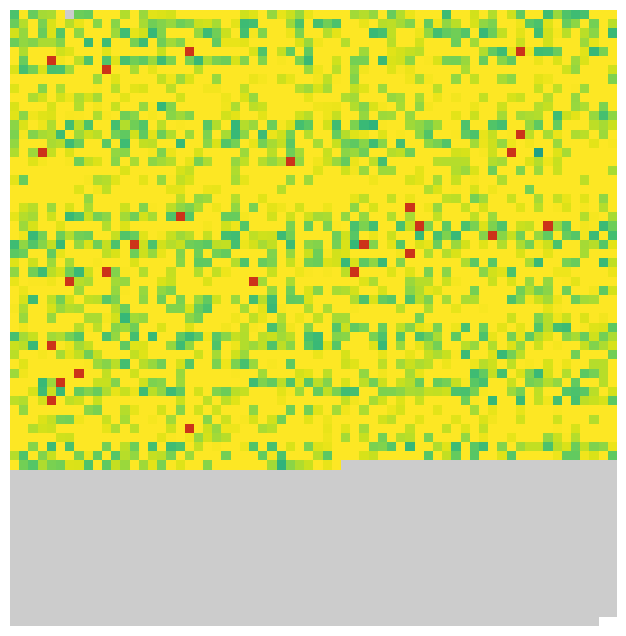

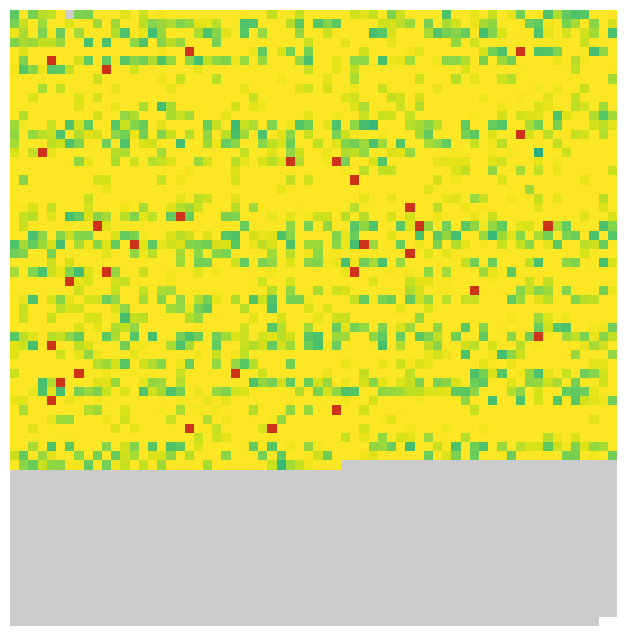

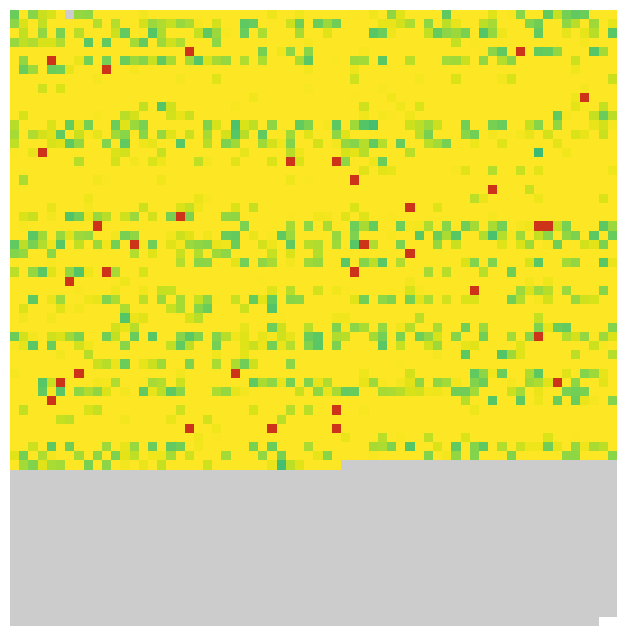

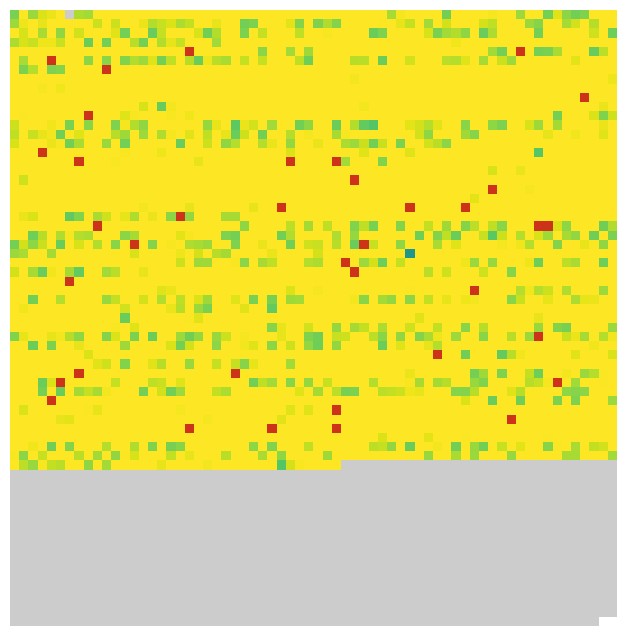

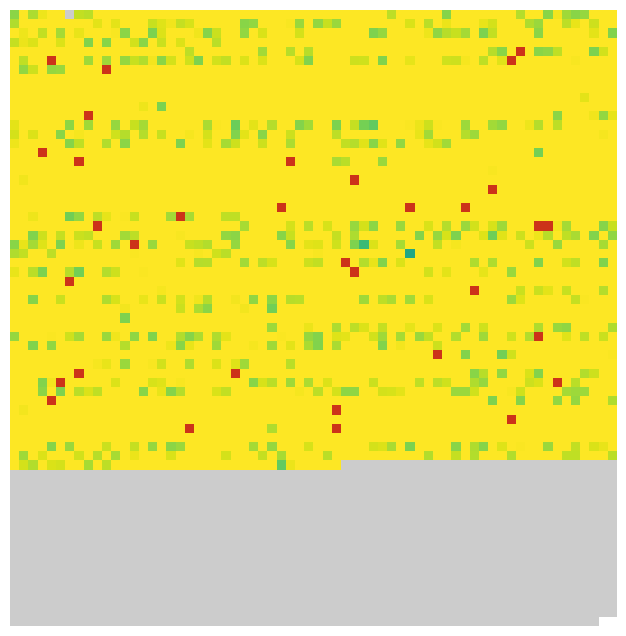

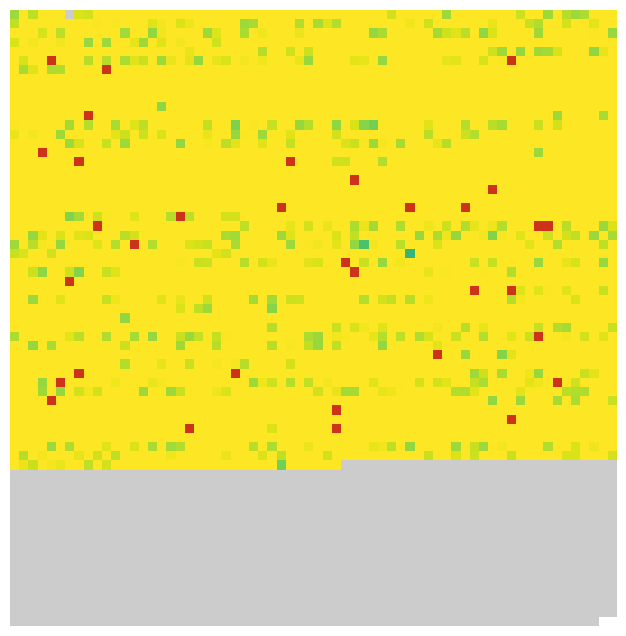

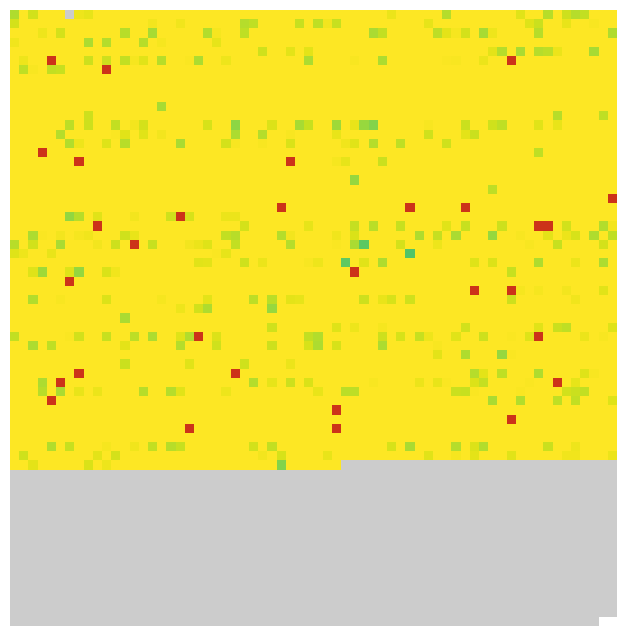

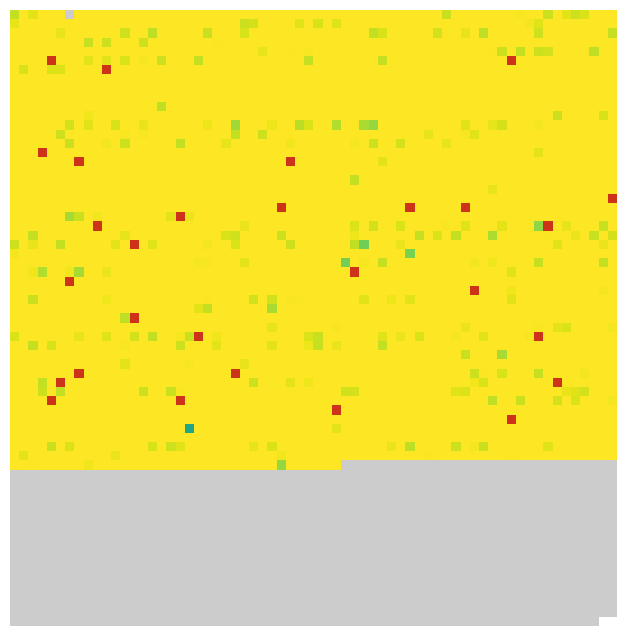

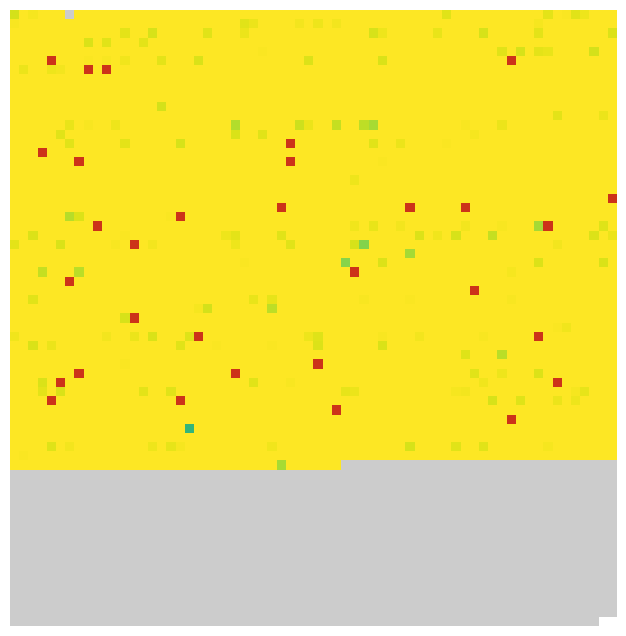

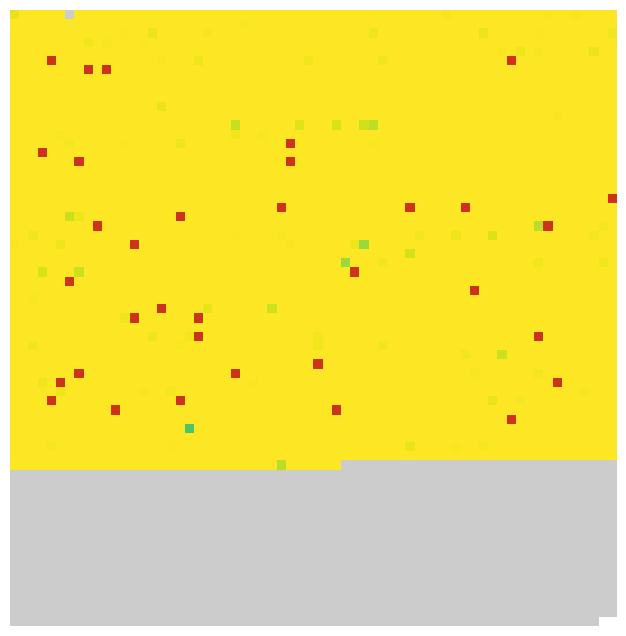

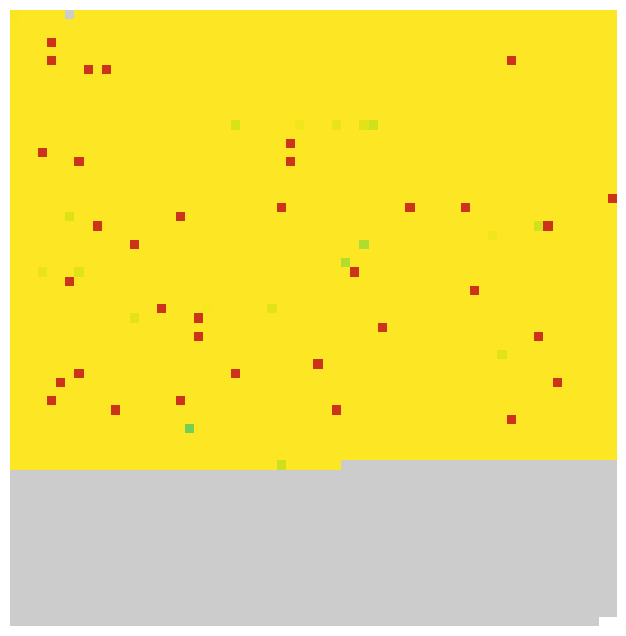

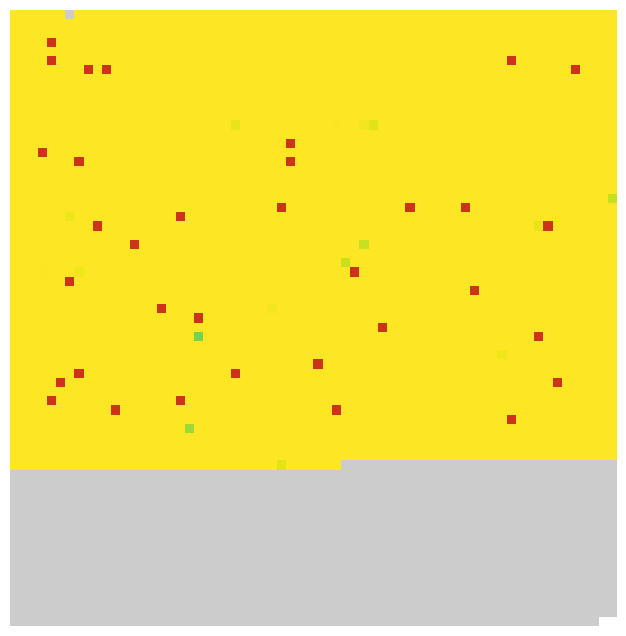

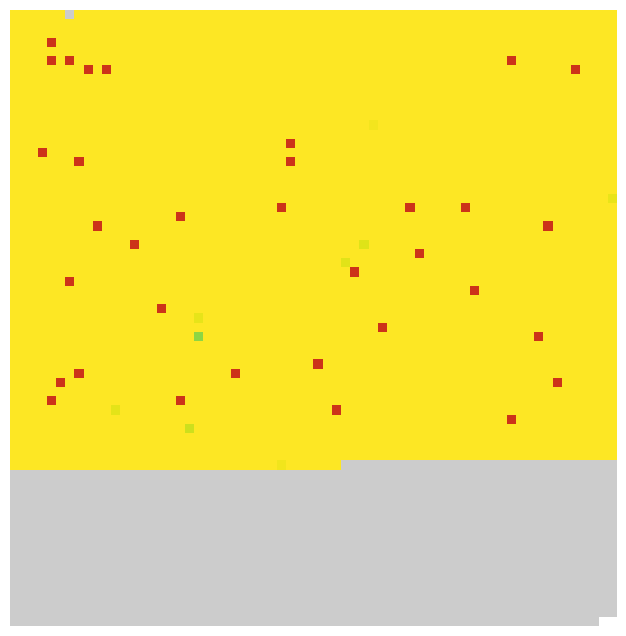

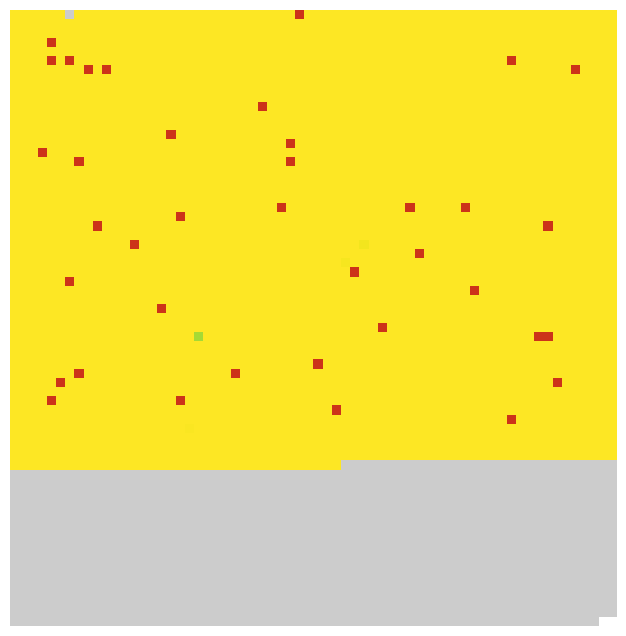

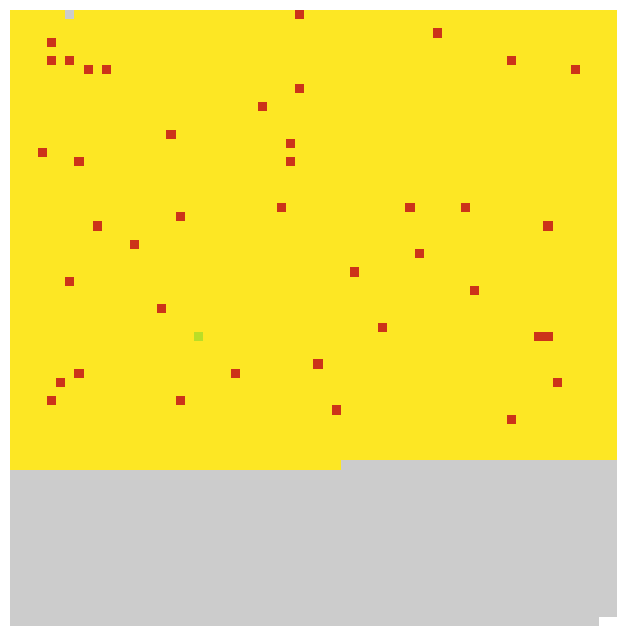

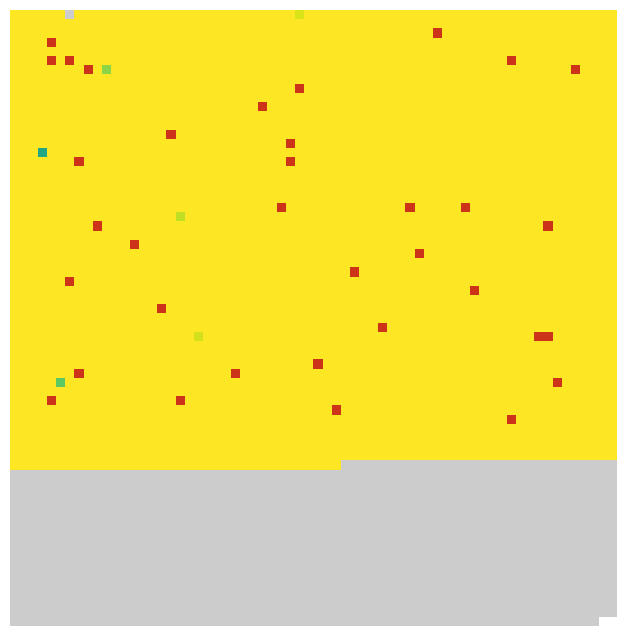

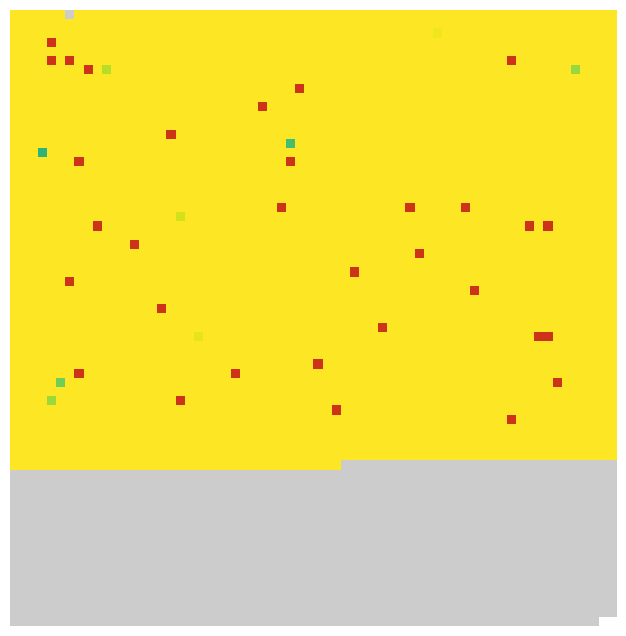

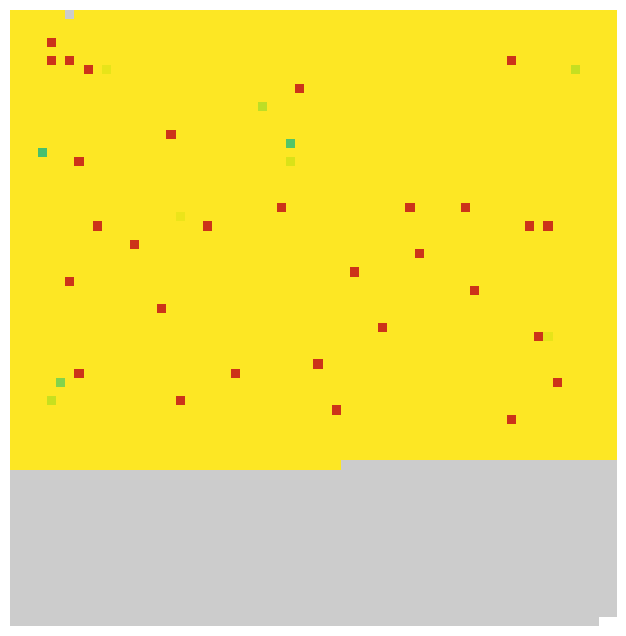

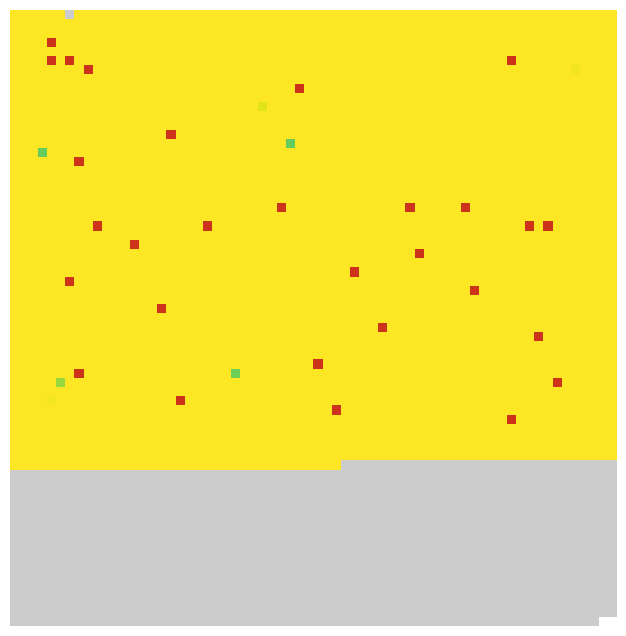

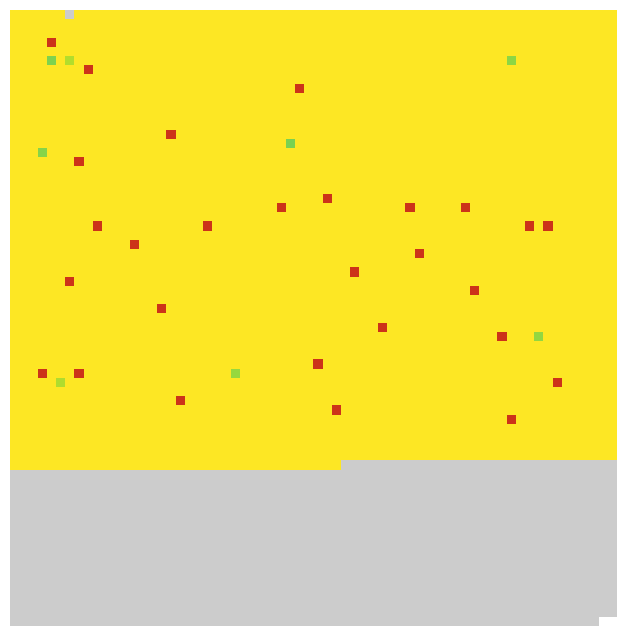

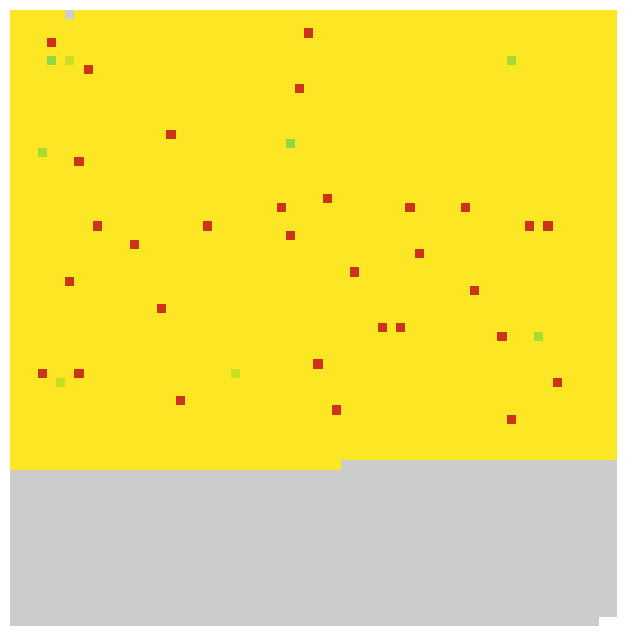

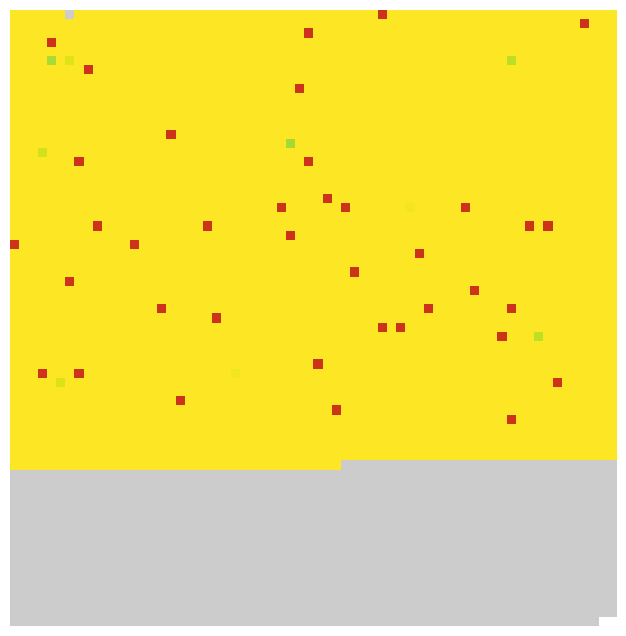

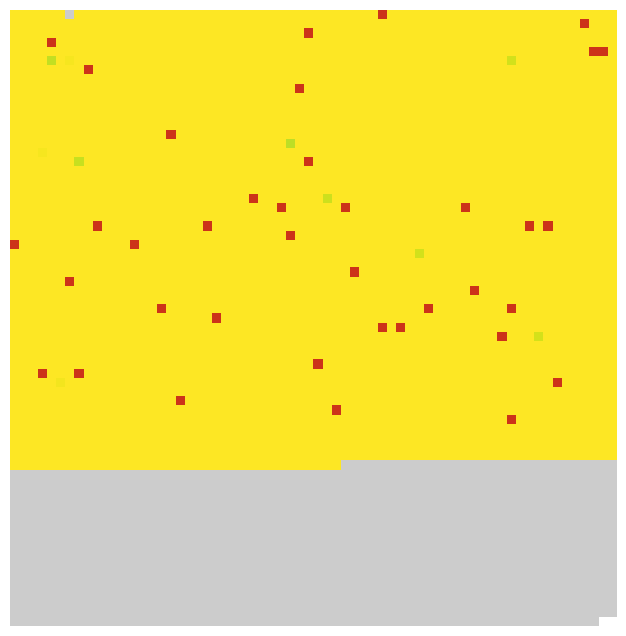

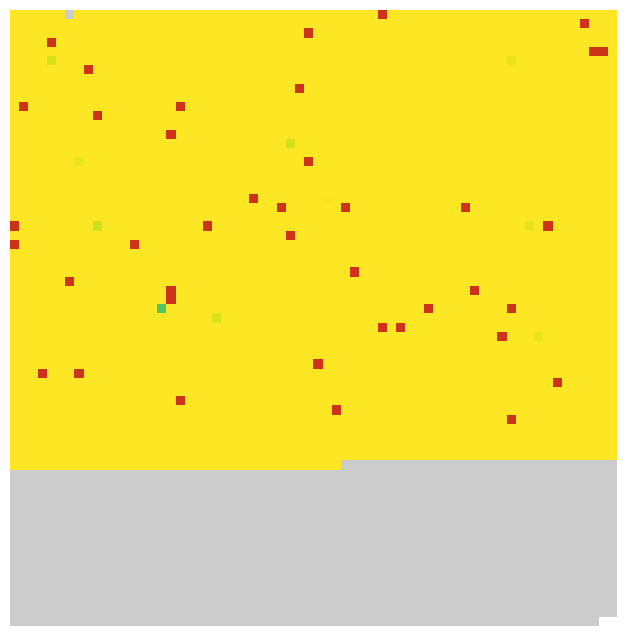

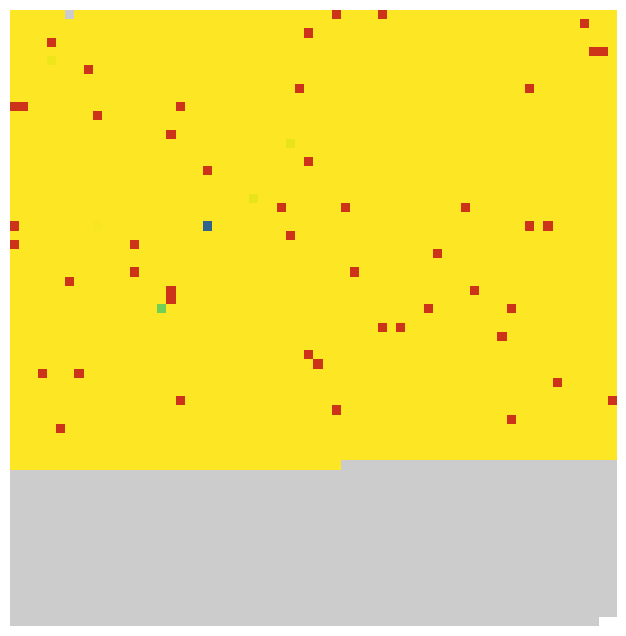

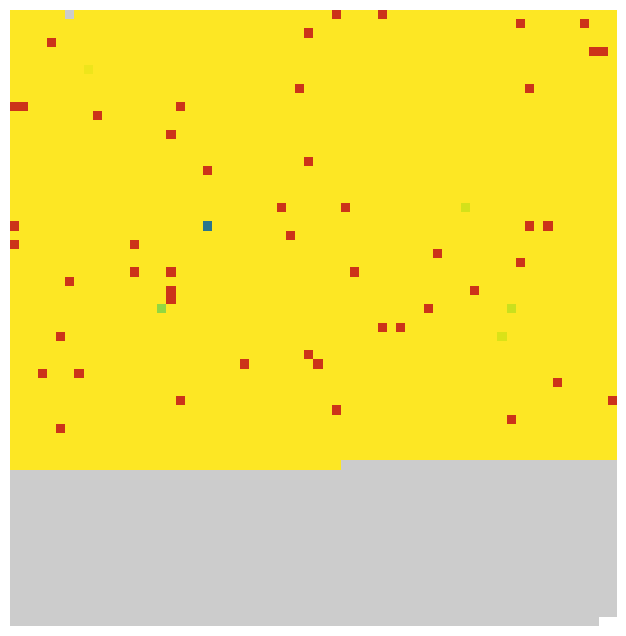

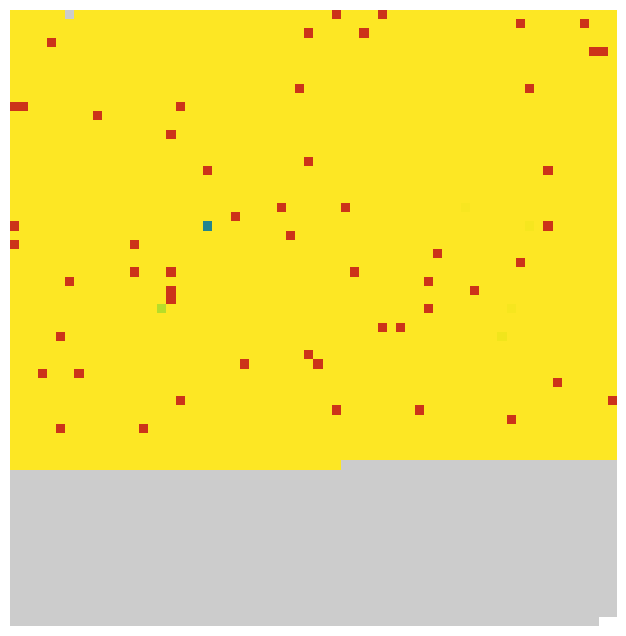

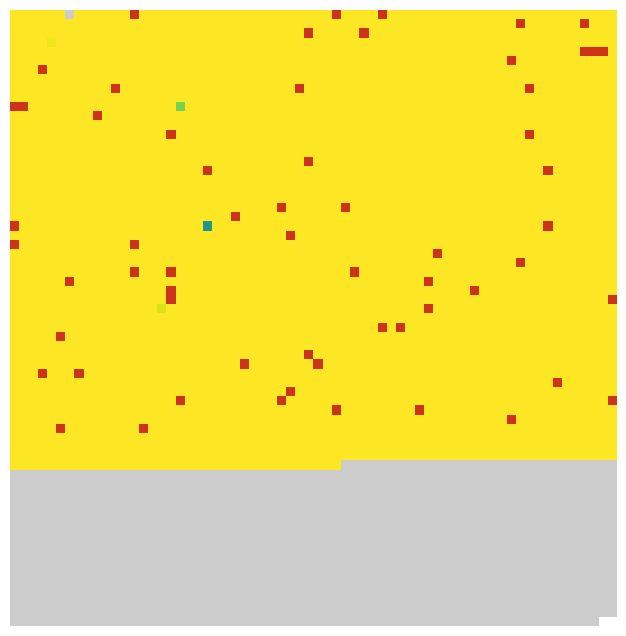

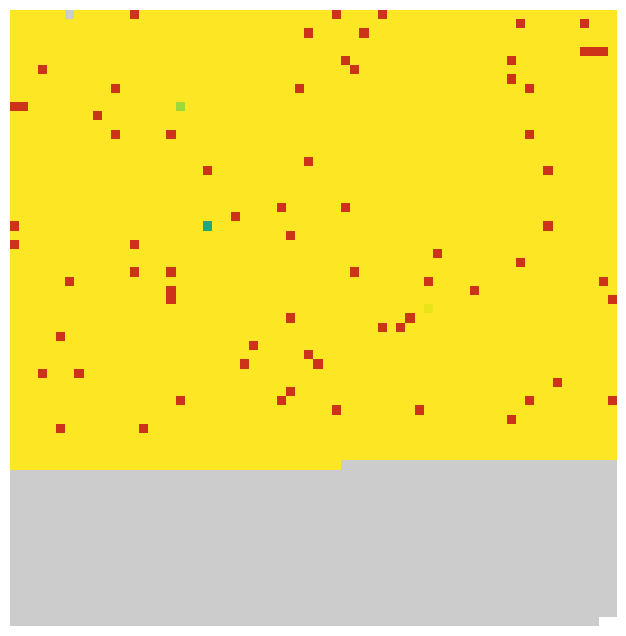

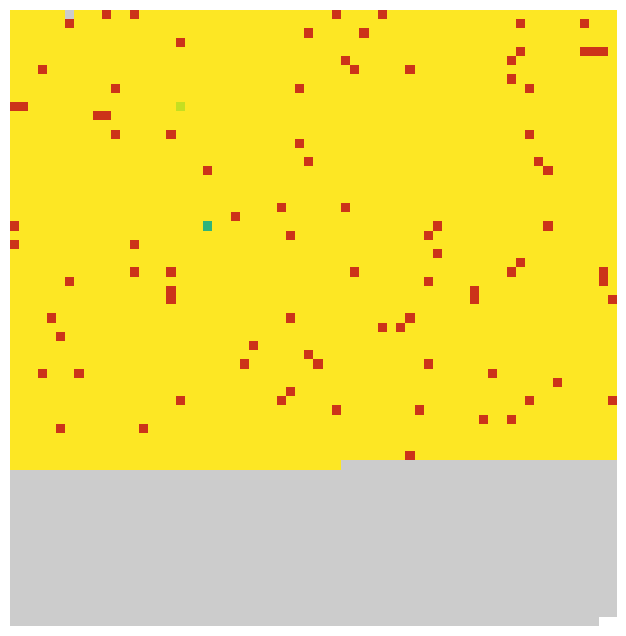

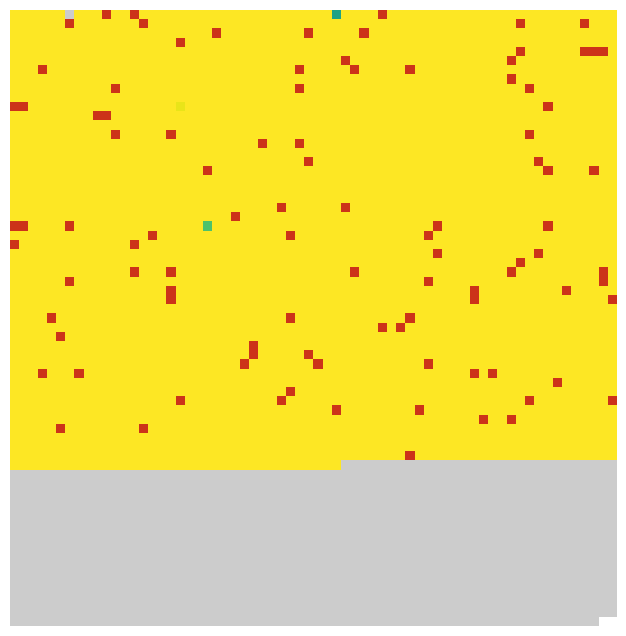

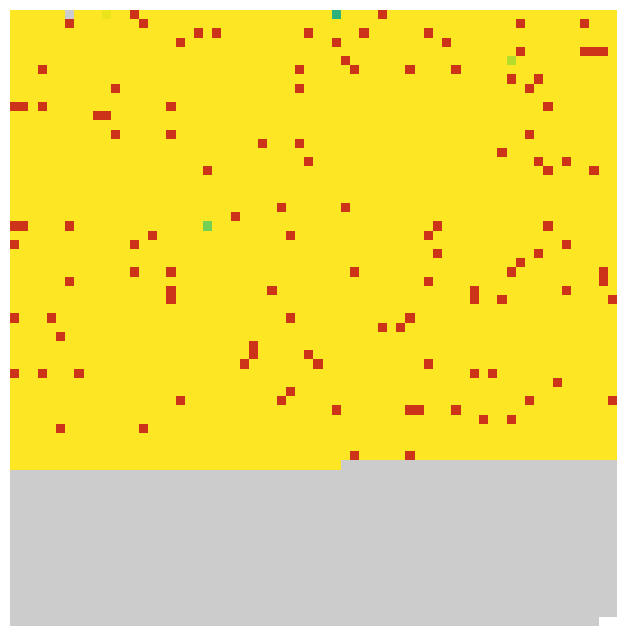

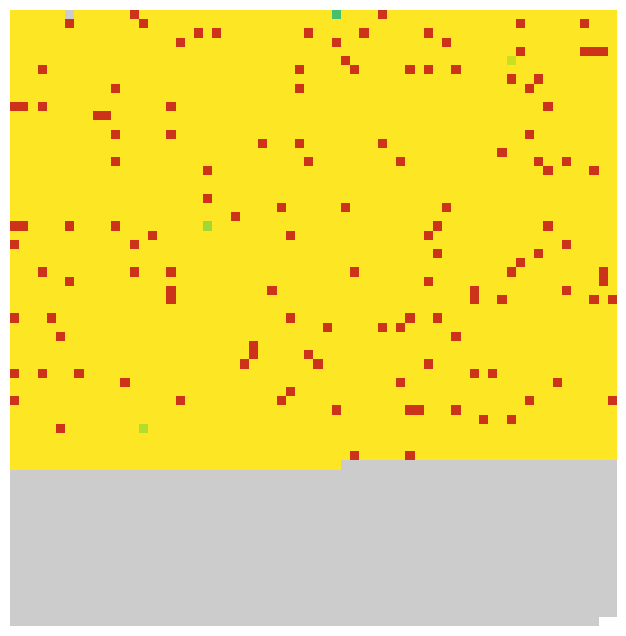

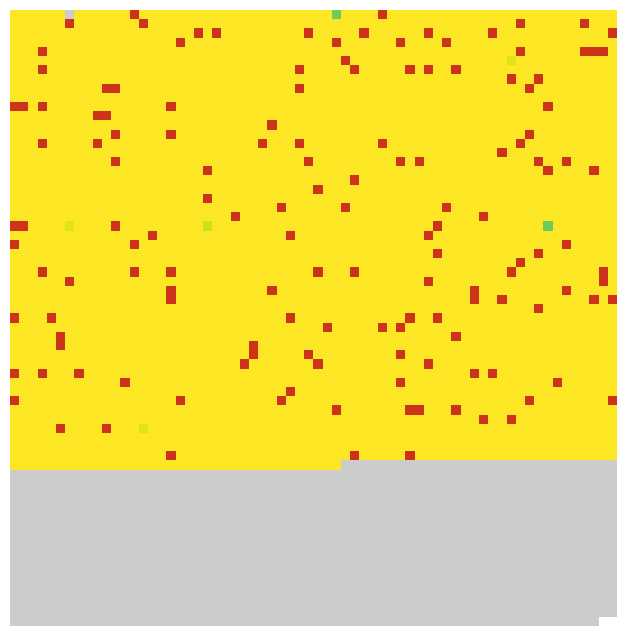

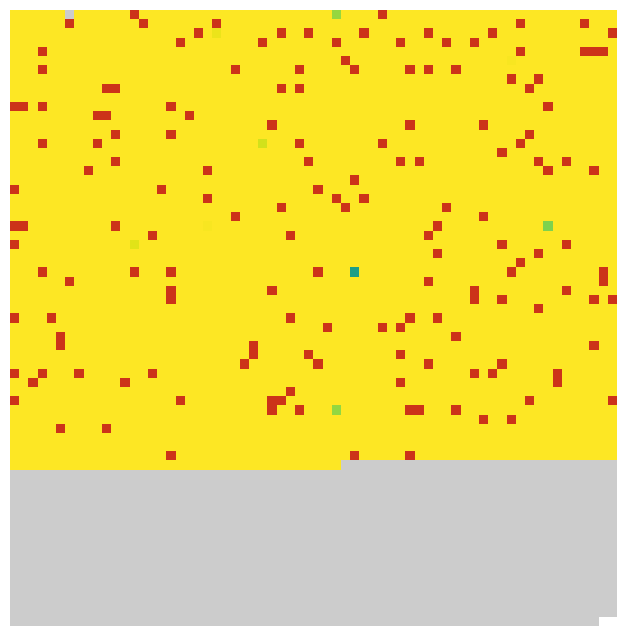

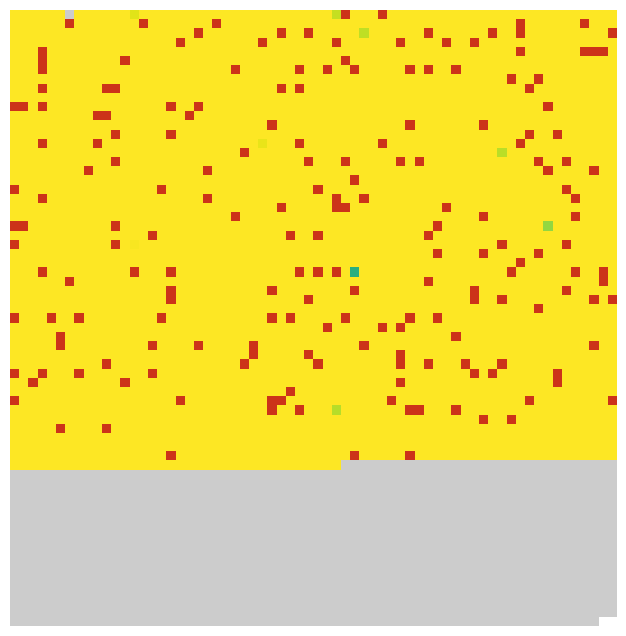

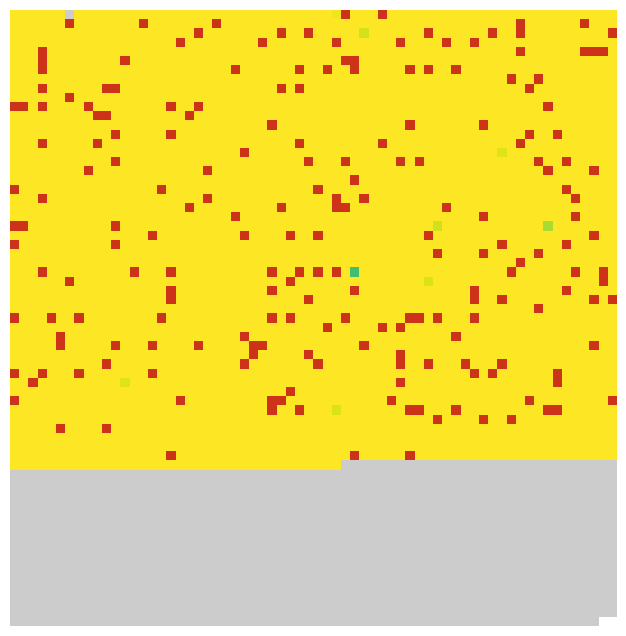

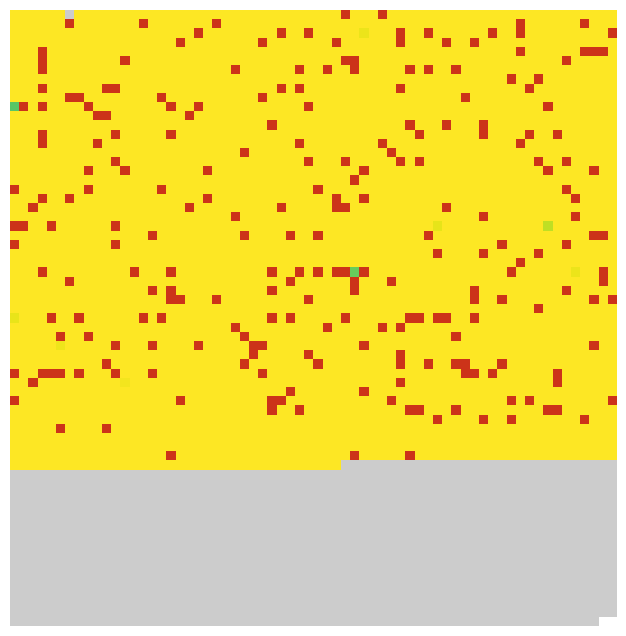

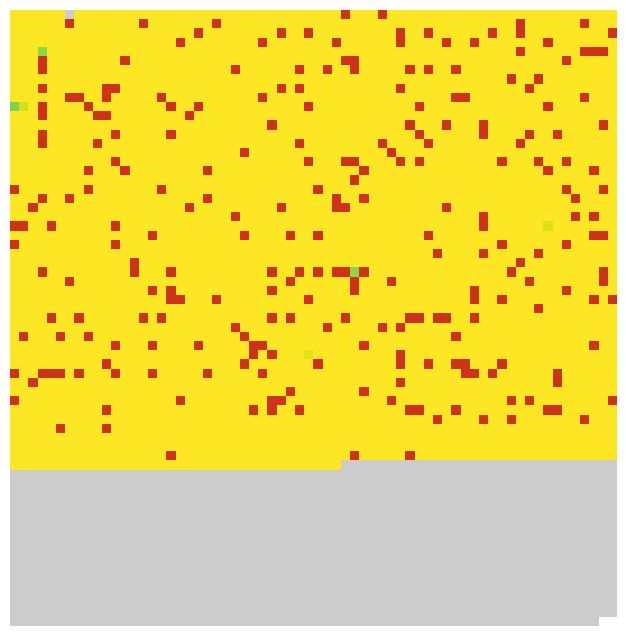

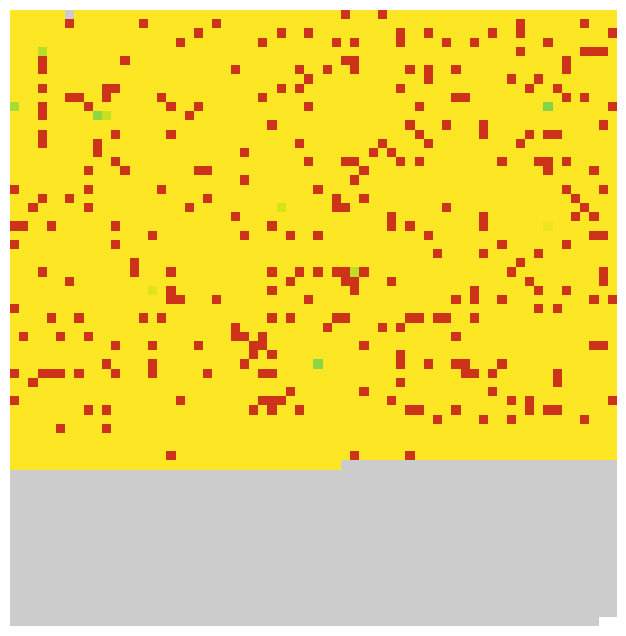

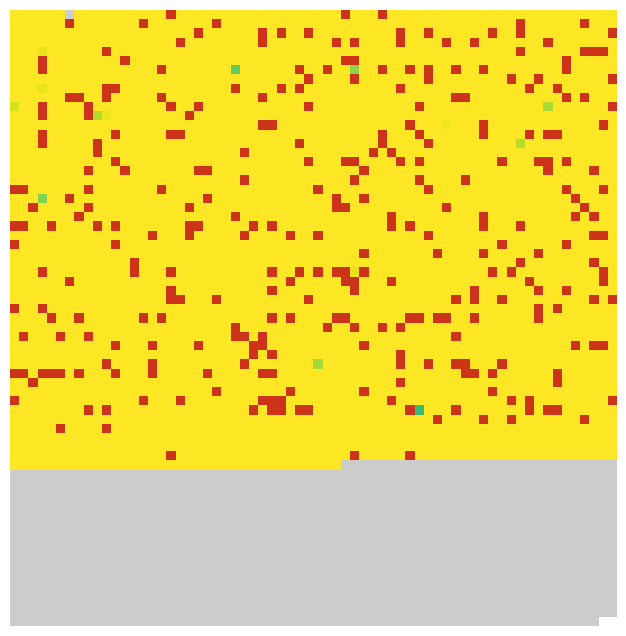

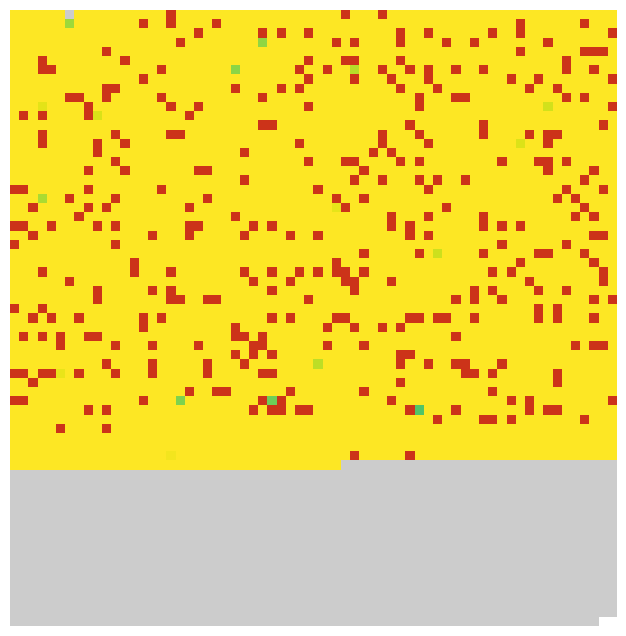

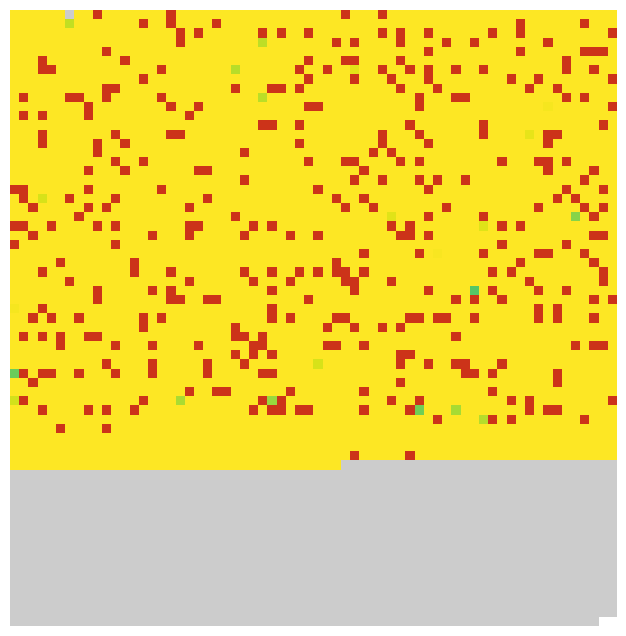

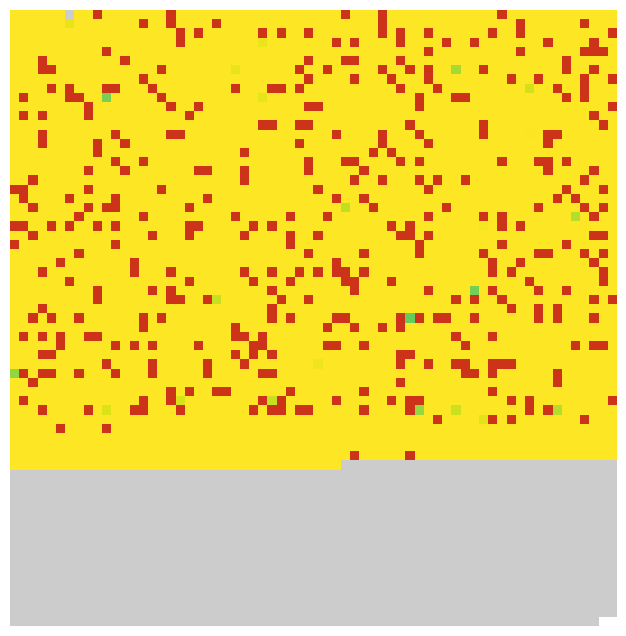

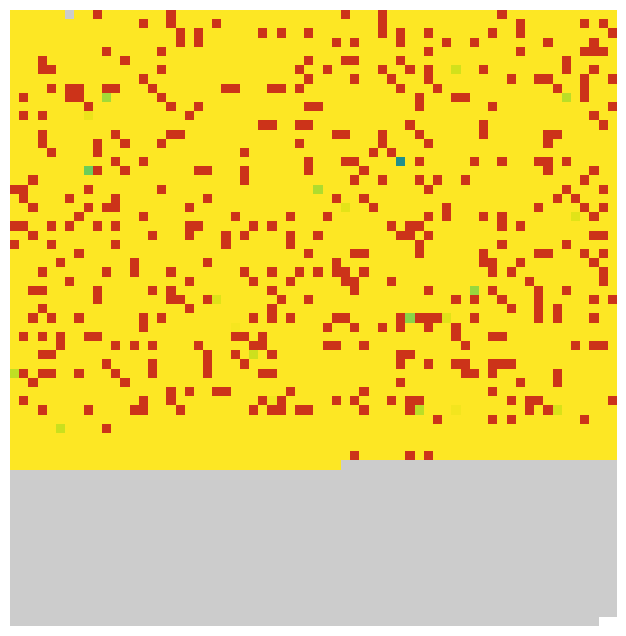

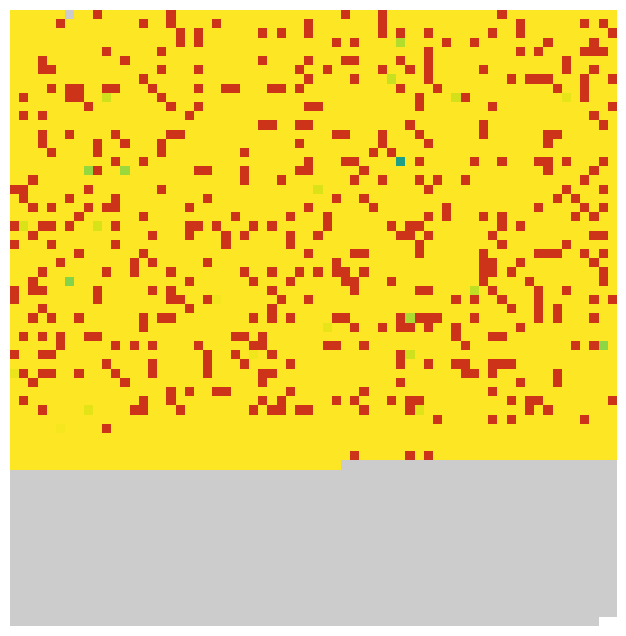

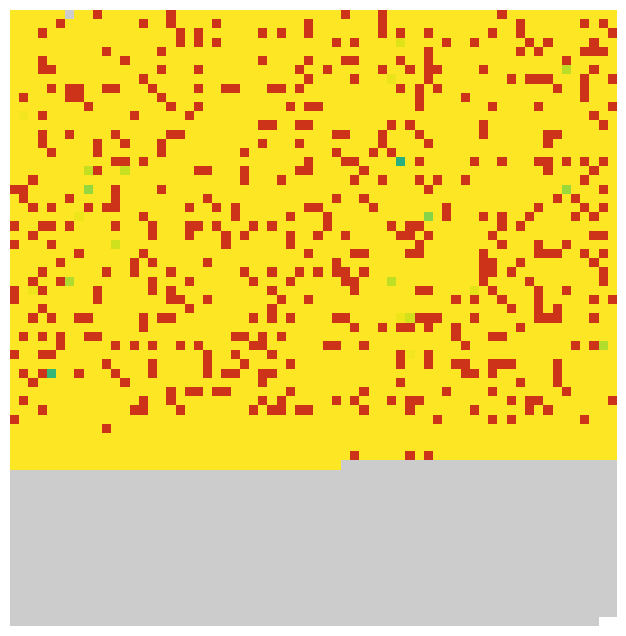

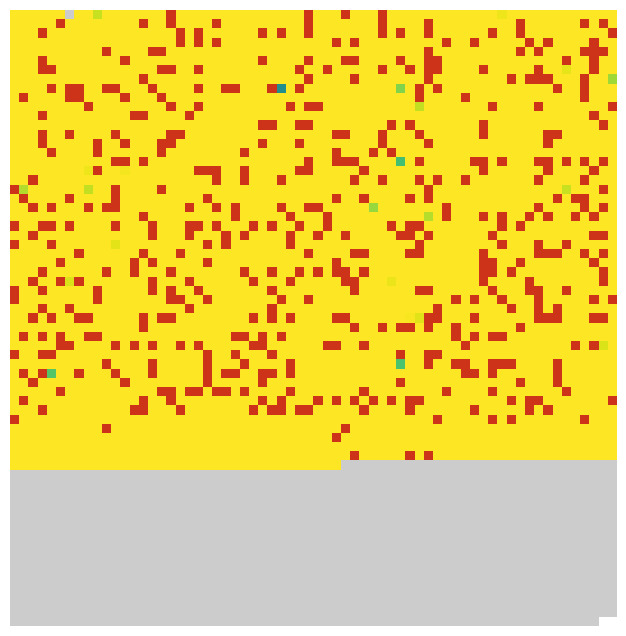

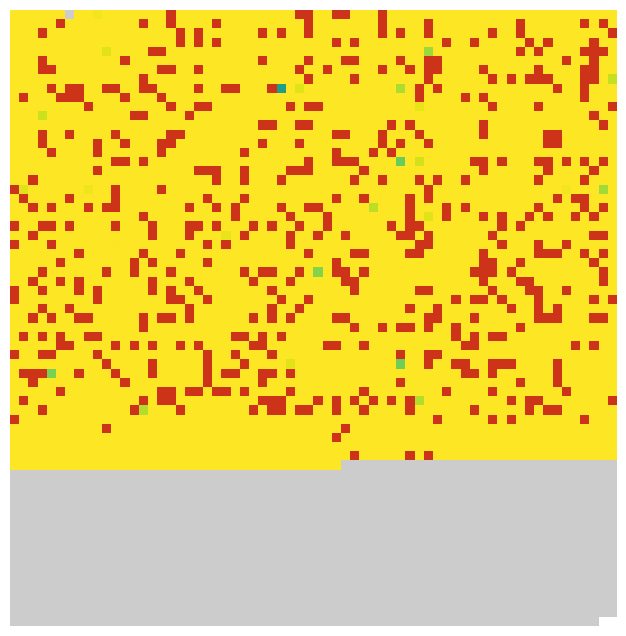

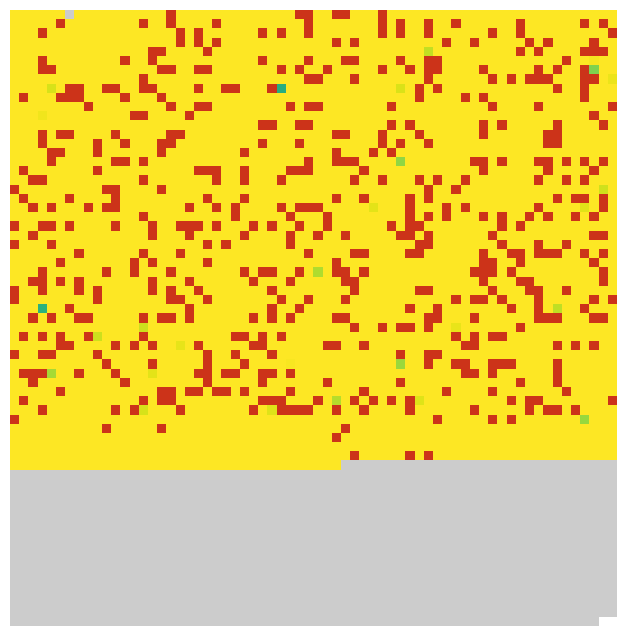

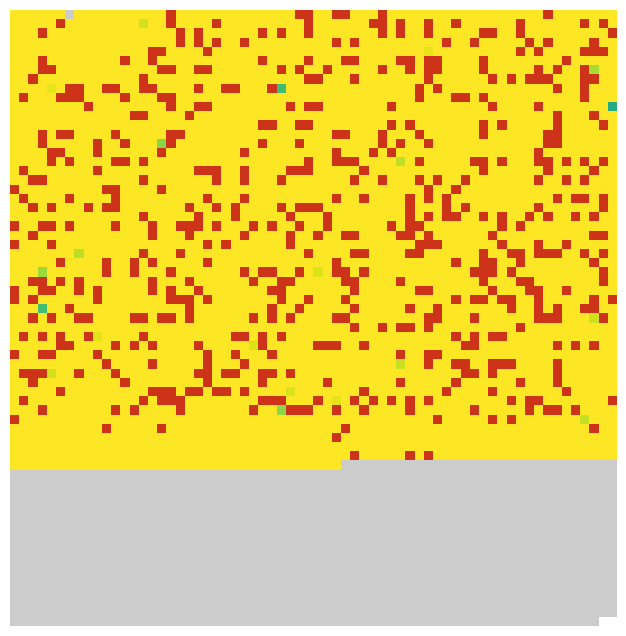

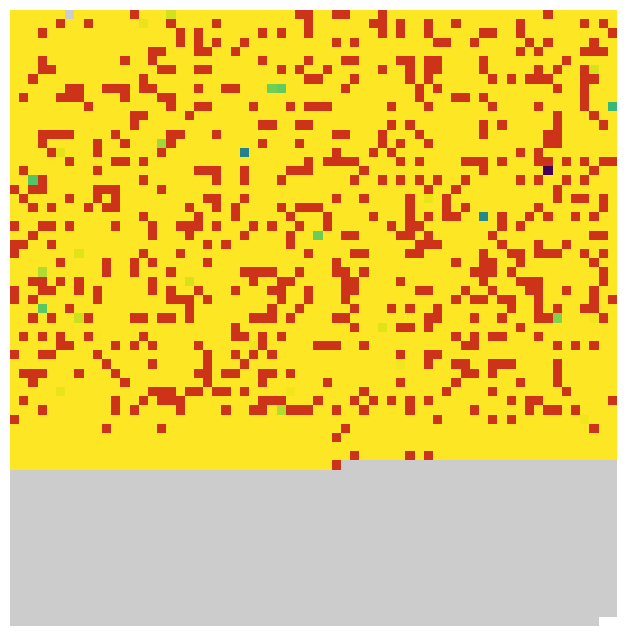

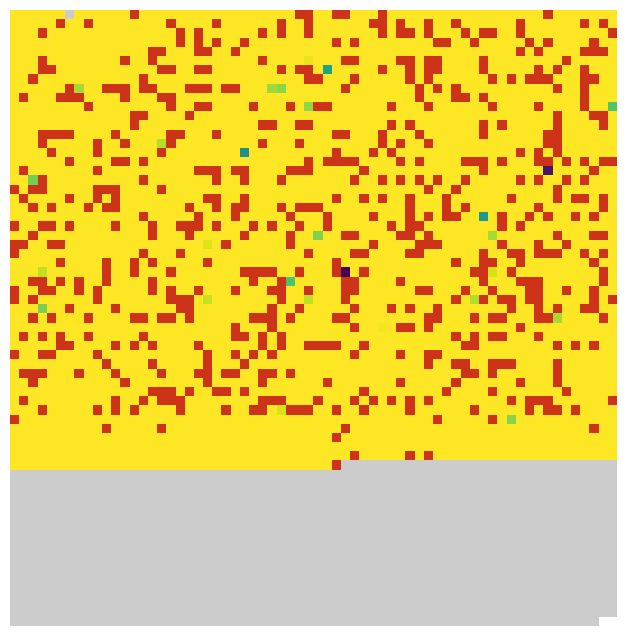

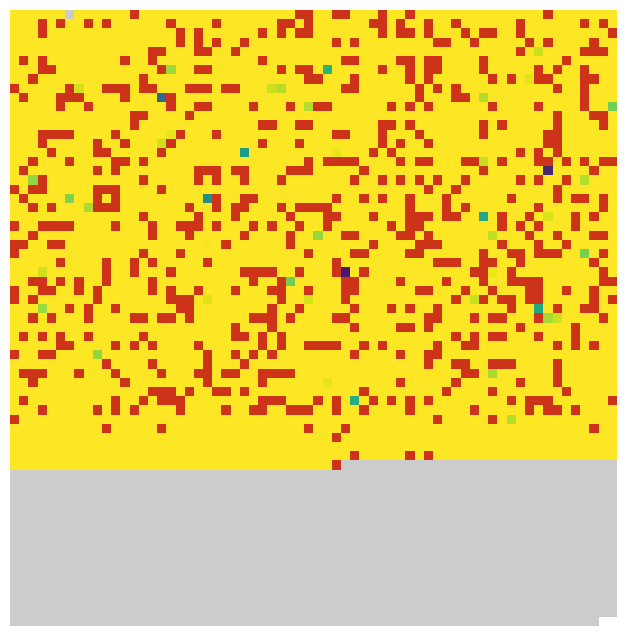

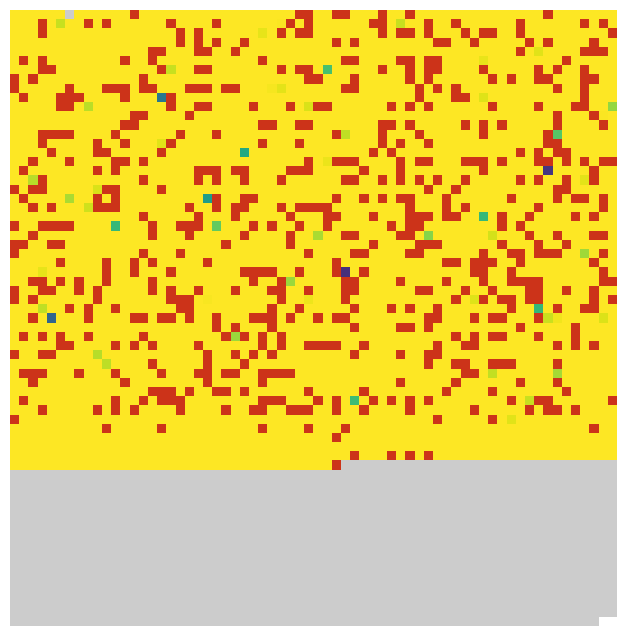

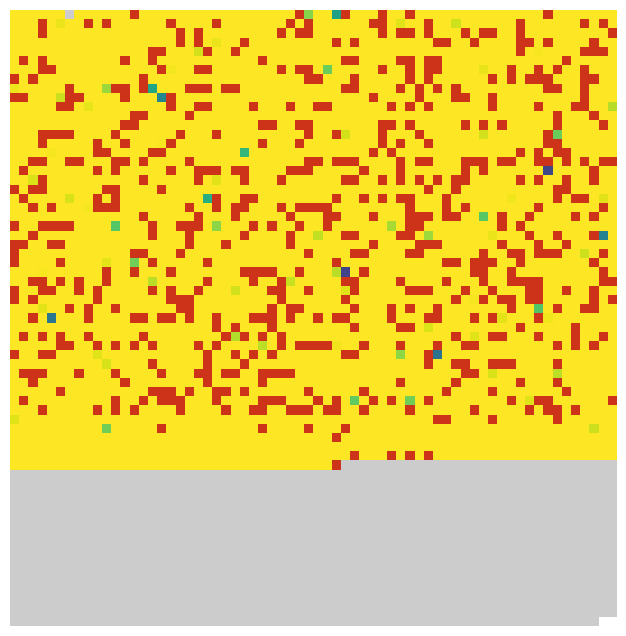

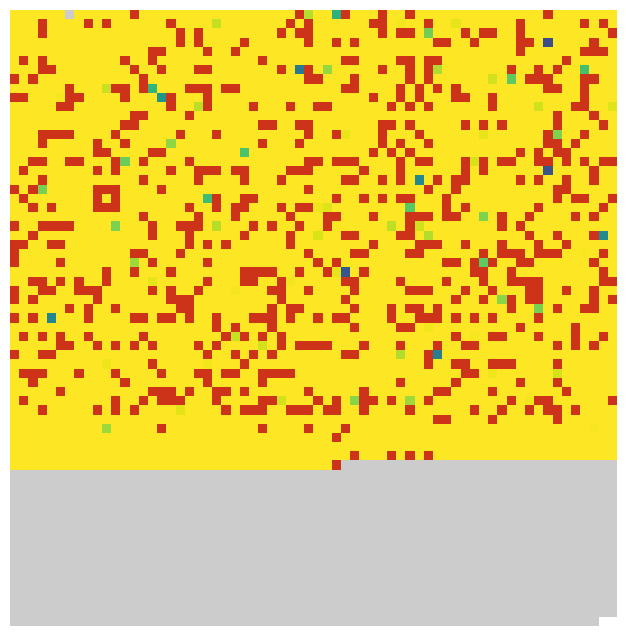

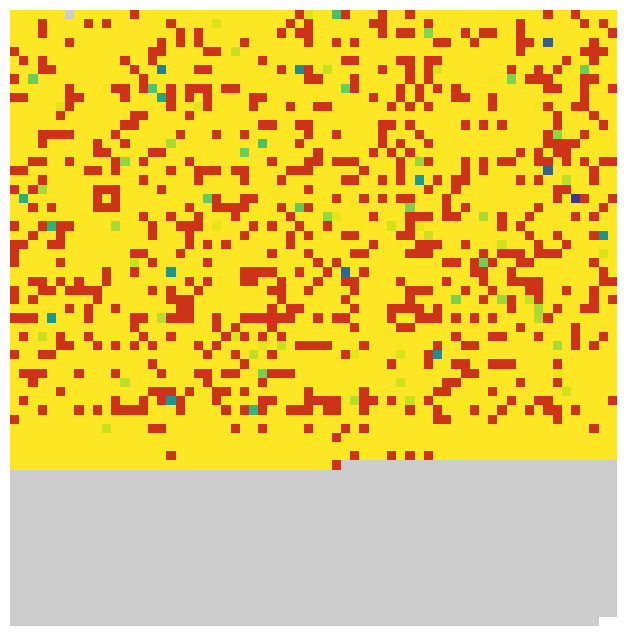

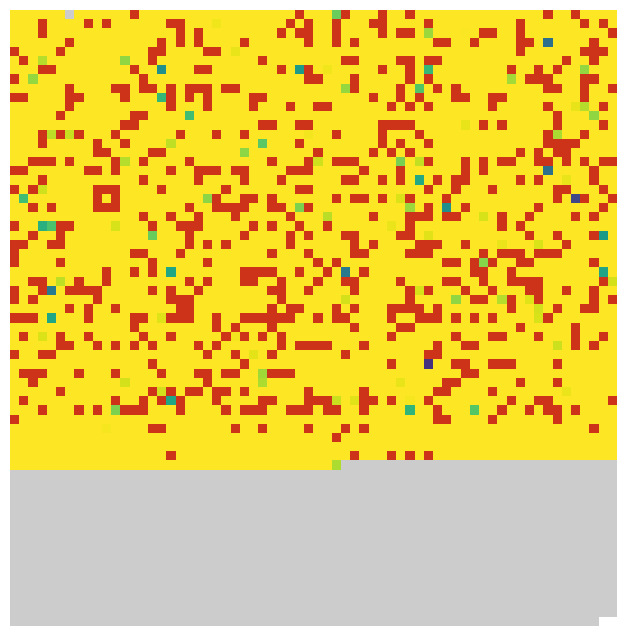

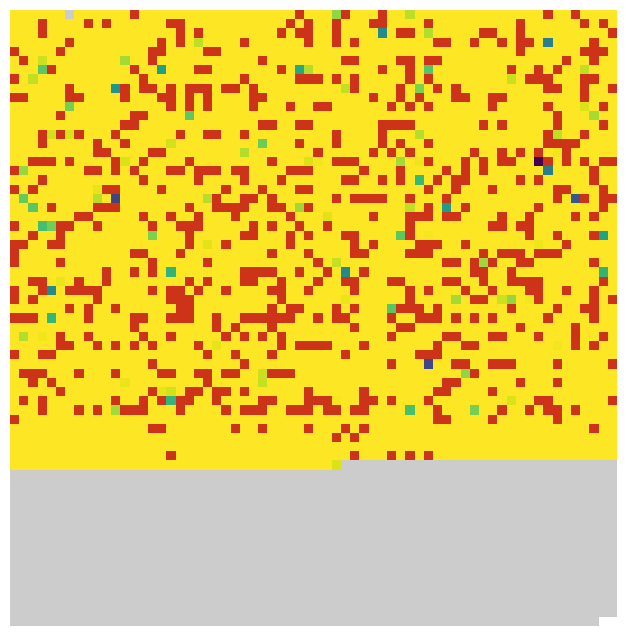

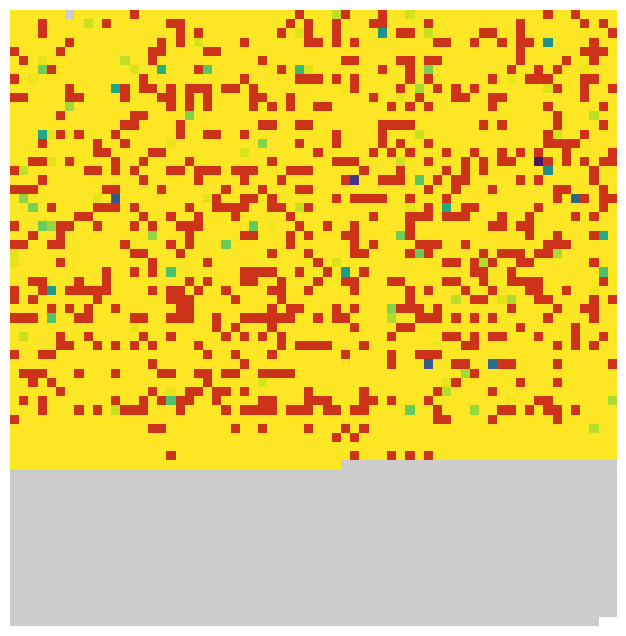

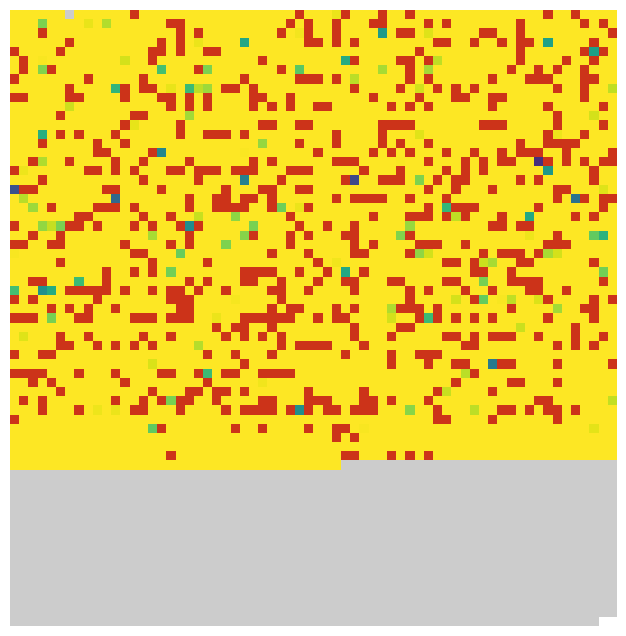

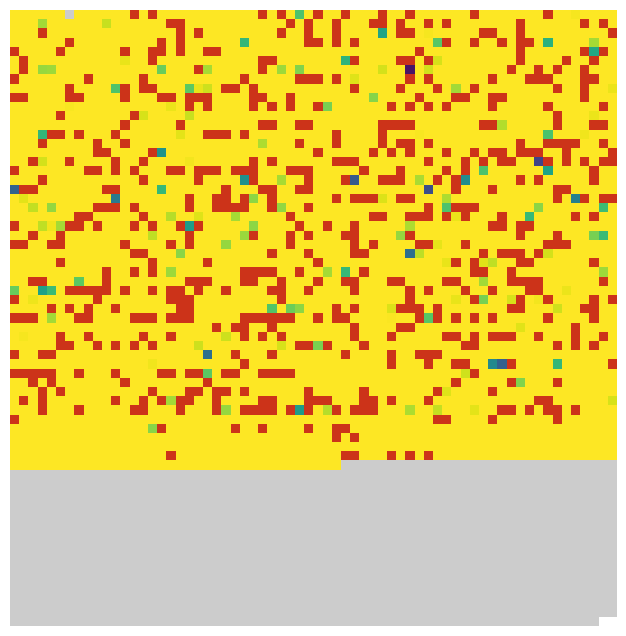

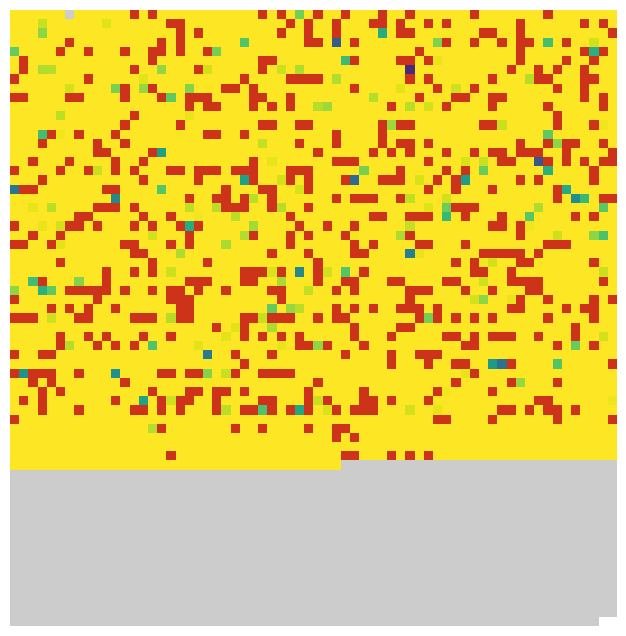

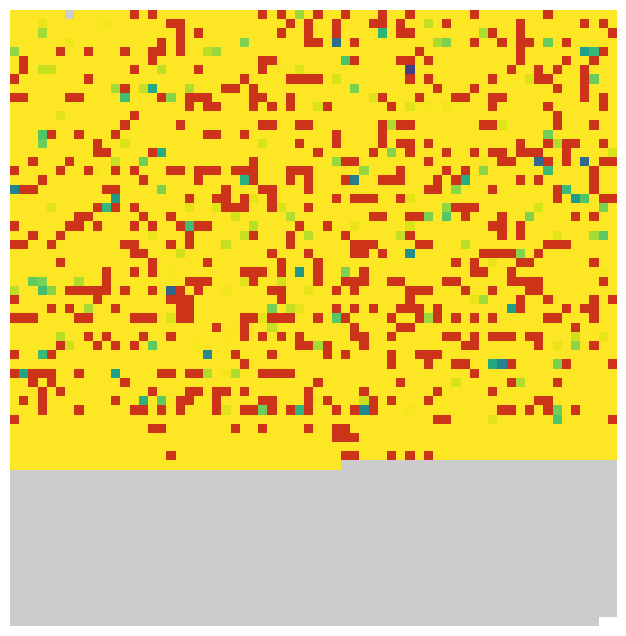

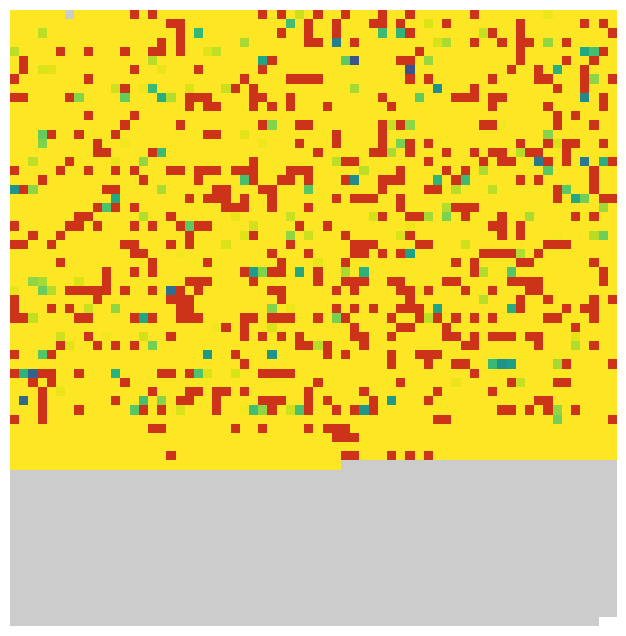

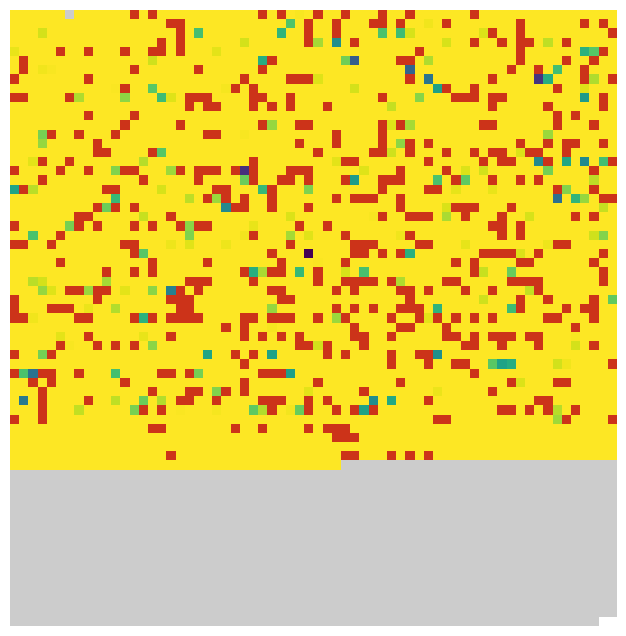

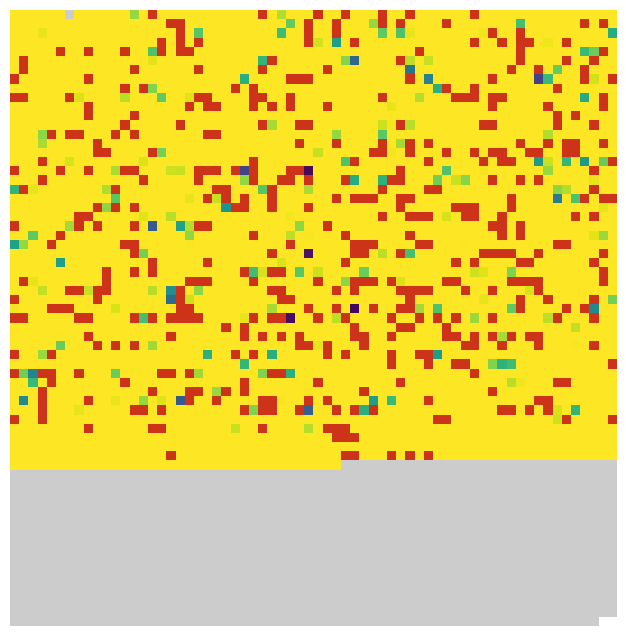

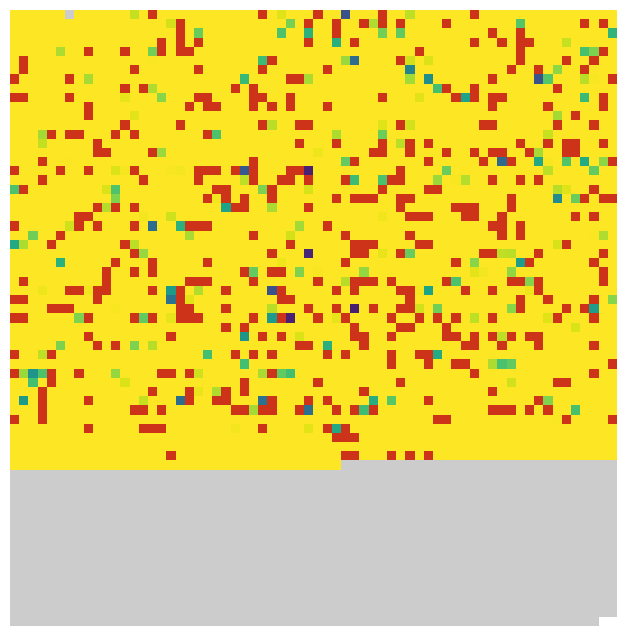

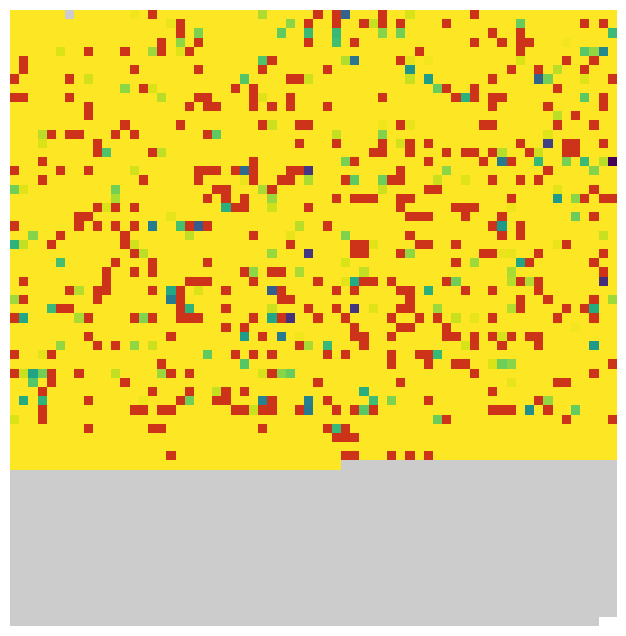

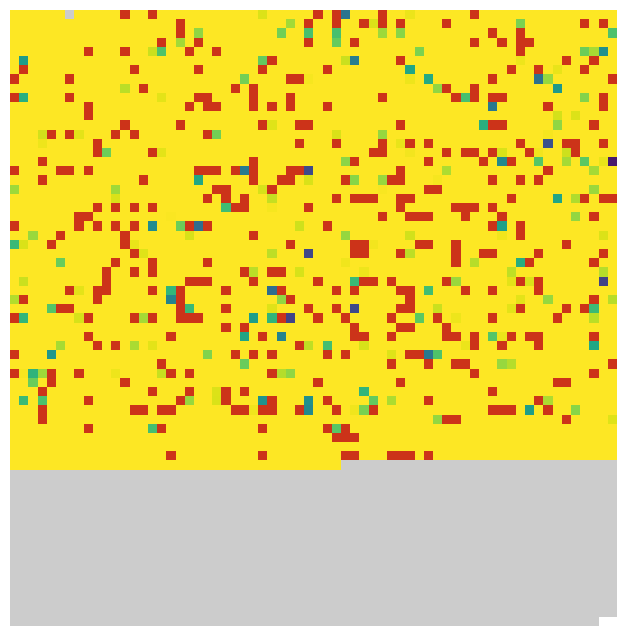

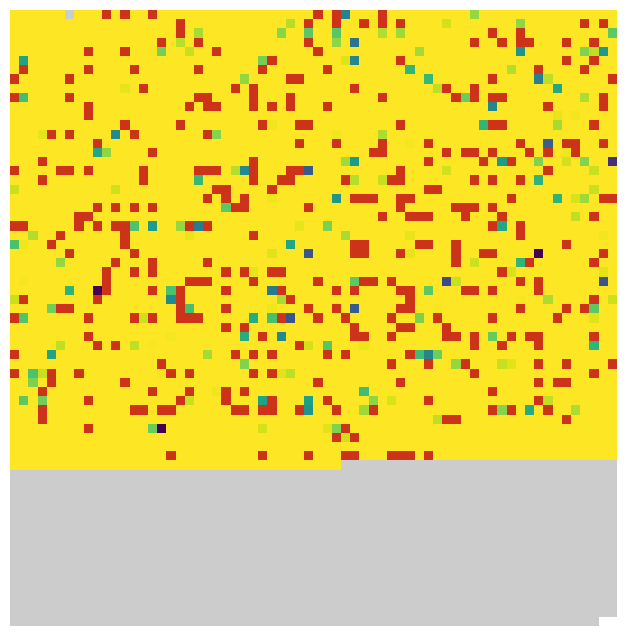

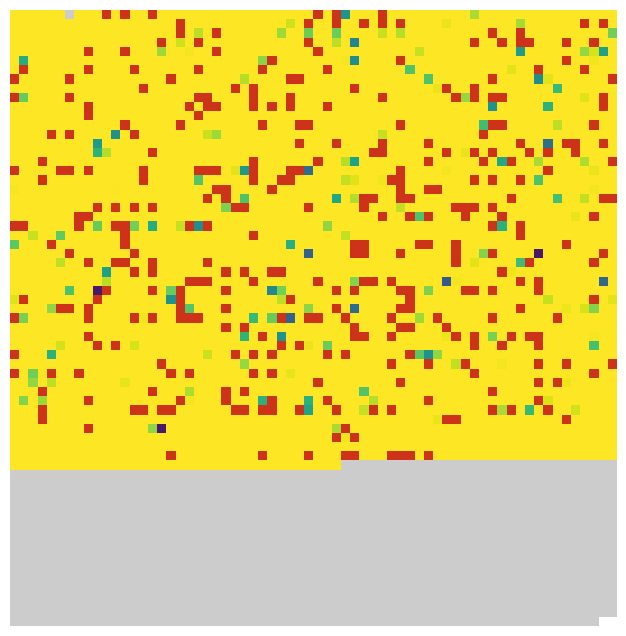

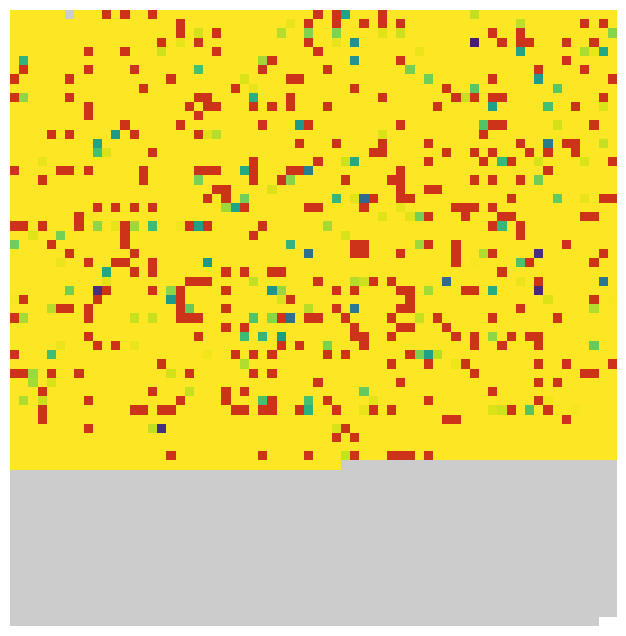

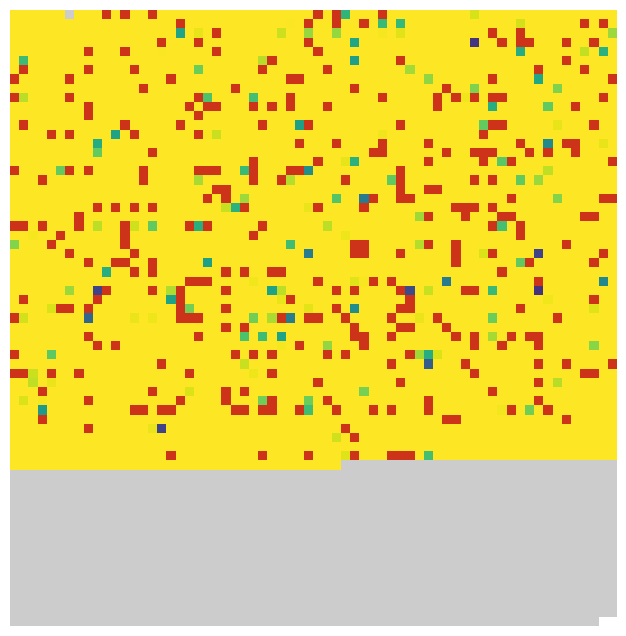

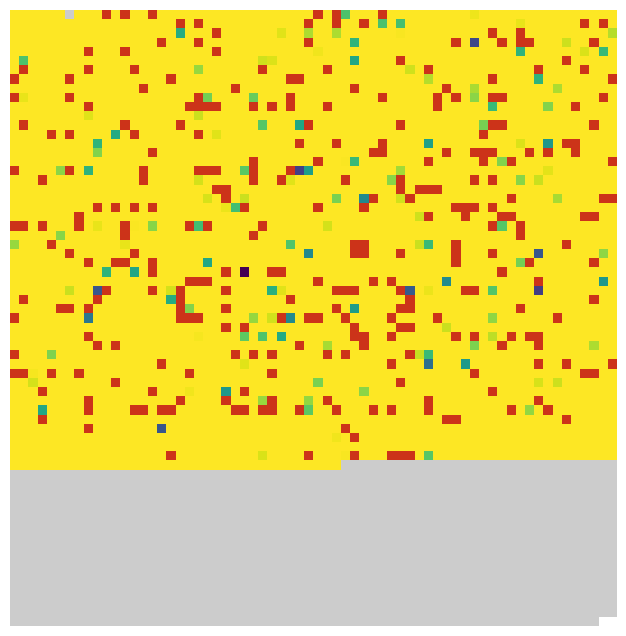

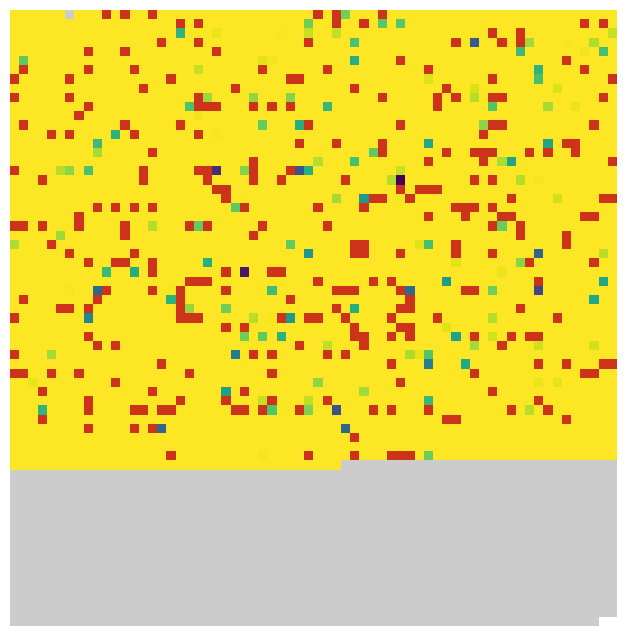

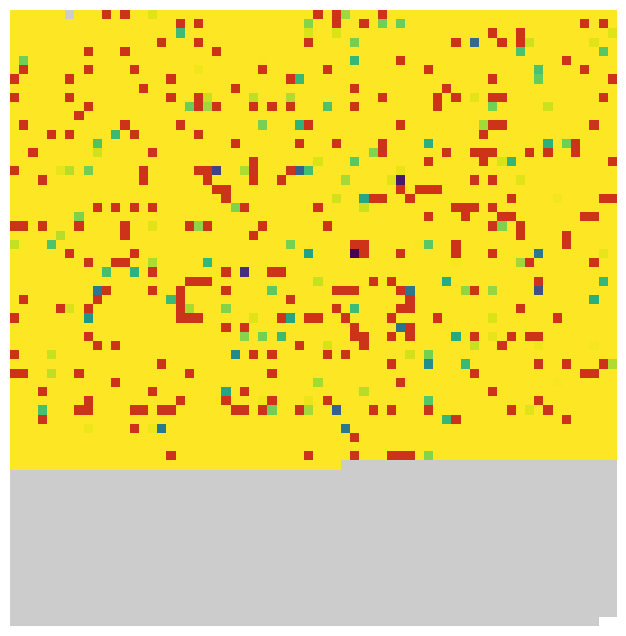

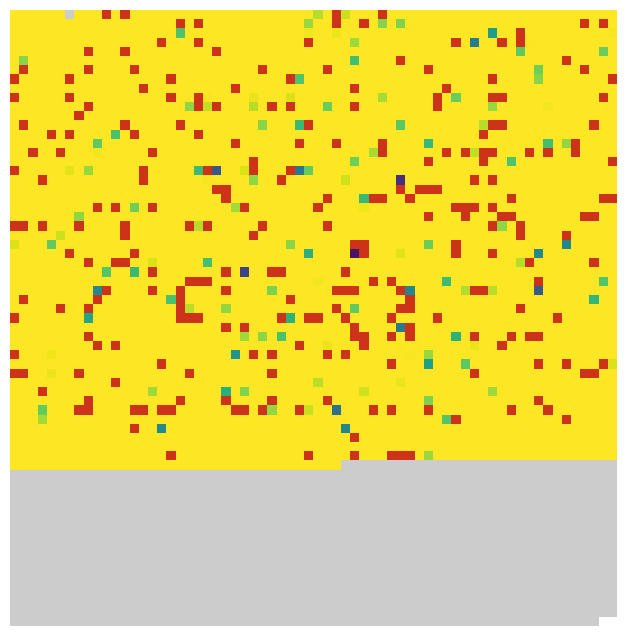

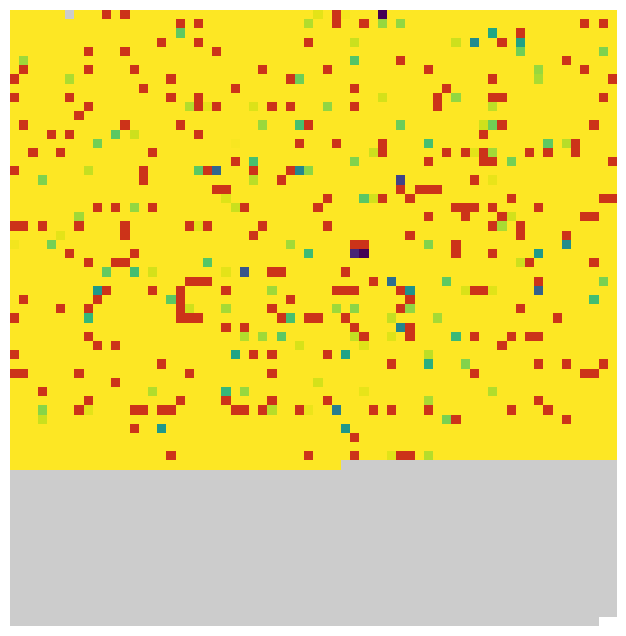

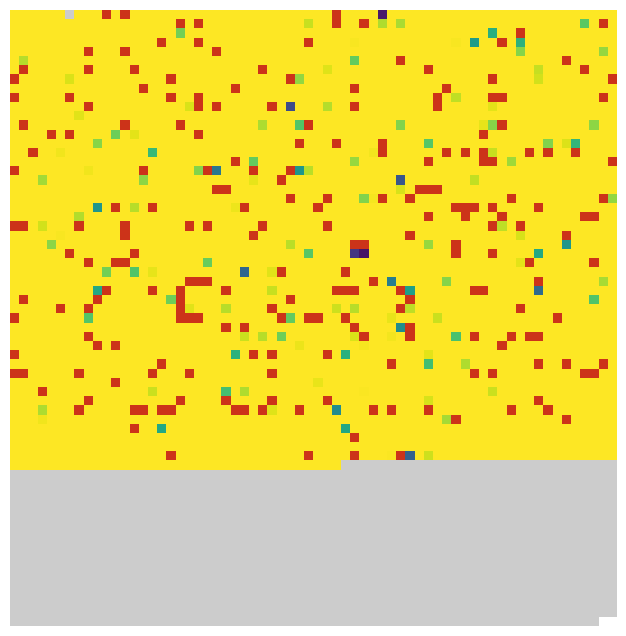

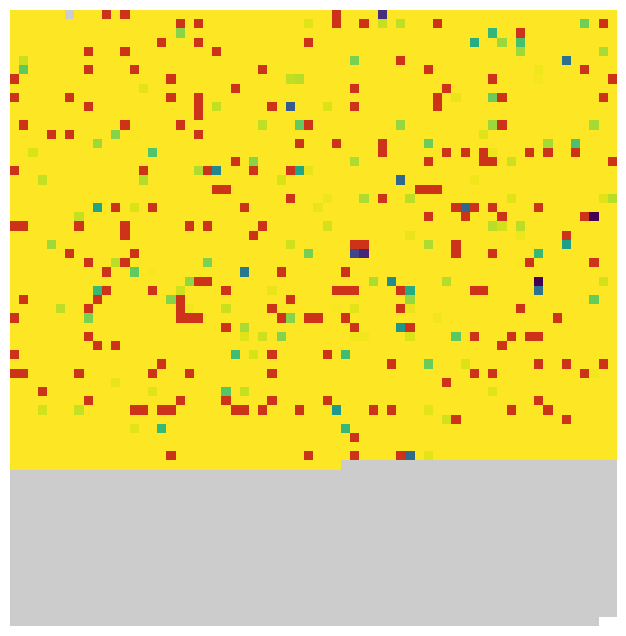

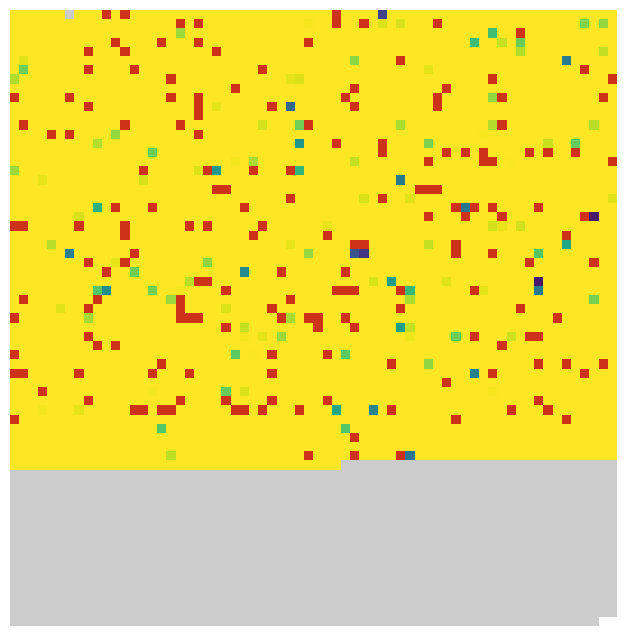

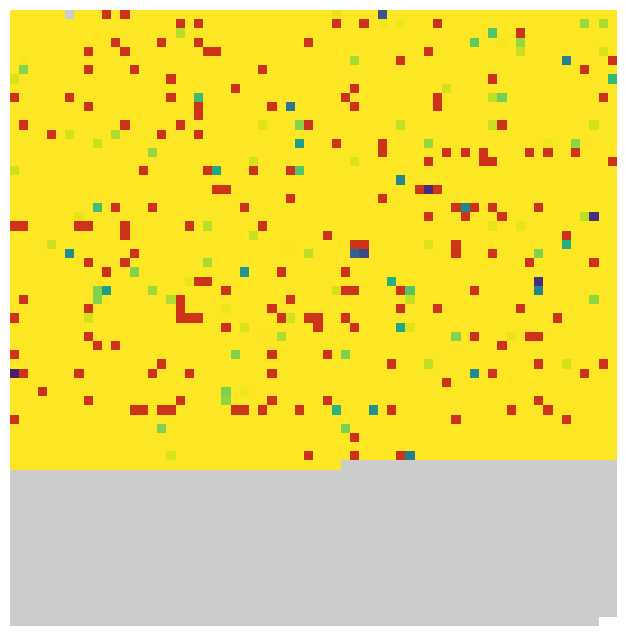

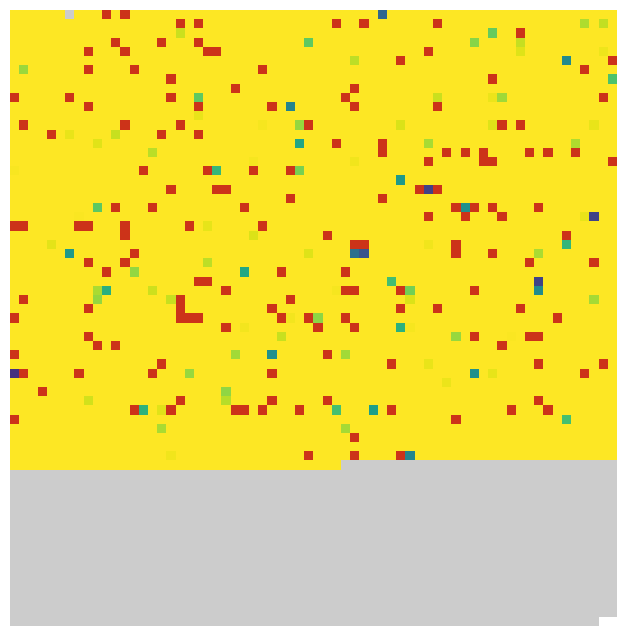

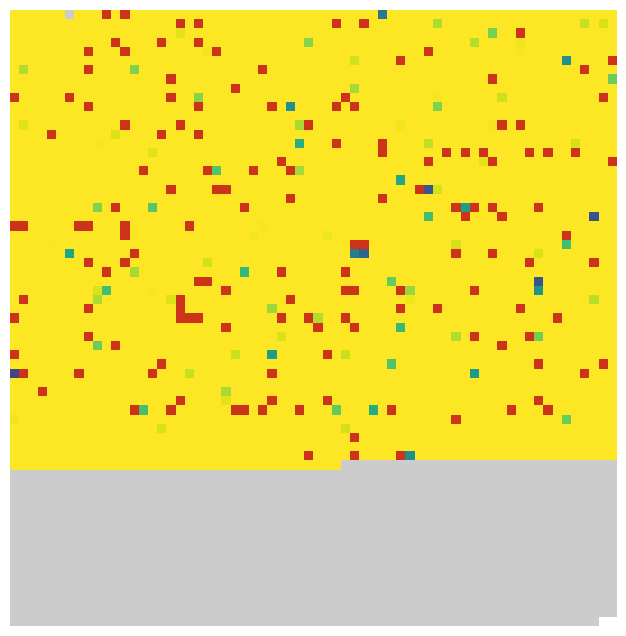

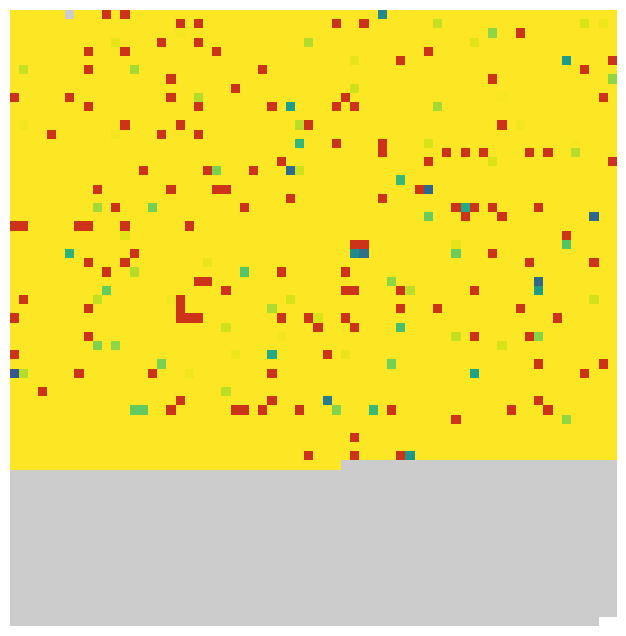

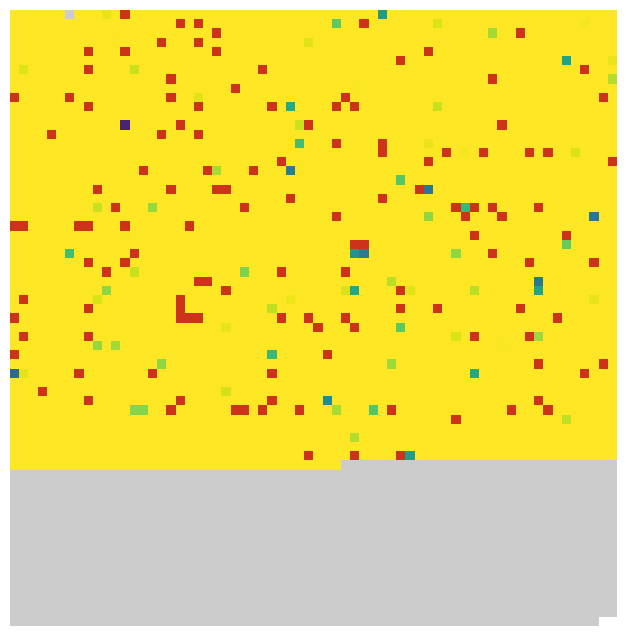

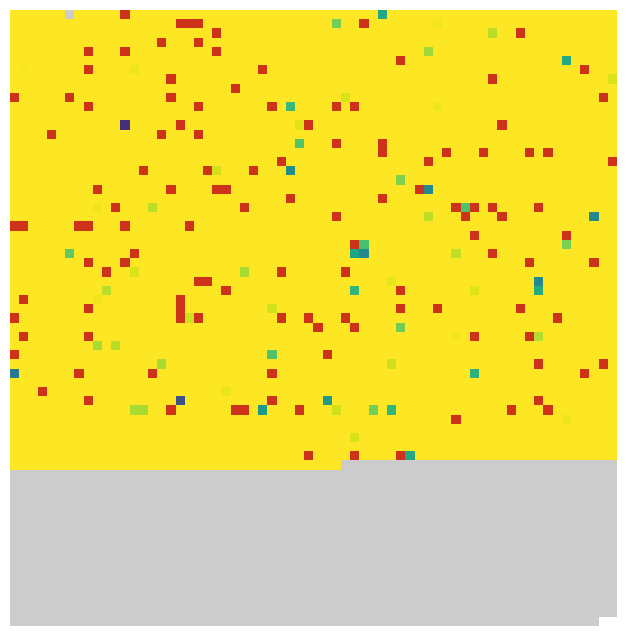

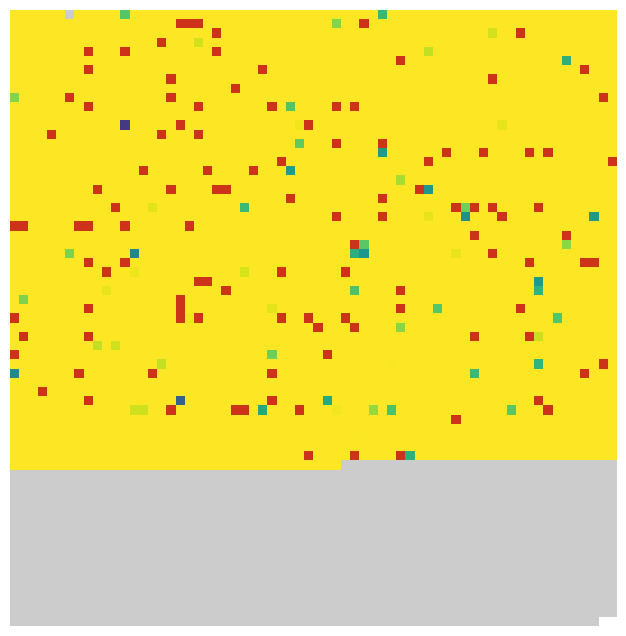

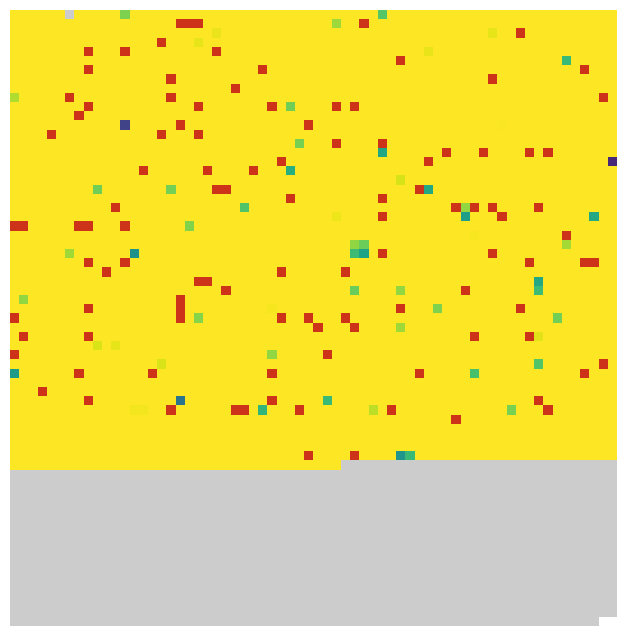

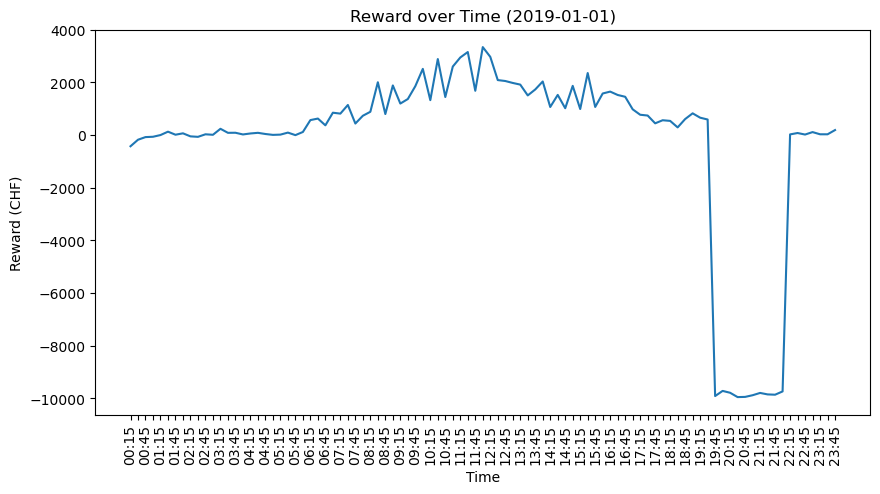

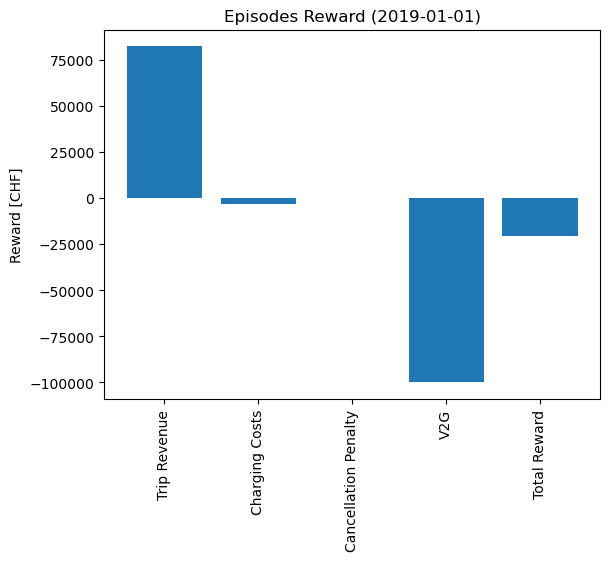

Total reward 2019-01-01:
-20720.28594118382


In [12]:
# simulate one day
nr_iterations = 1

# get number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0
# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)
    
    # load discrete planned reservation table
    sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_reservations = pd.read_sql(sql, engine)
    
    # load discrete planned reservation duration table
    sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_durations = pd.read_sql(sql, engine)
        
    # iteration for each day
    for day in range(98,676,96):
        
        # calculate number of timesteps since first day of simulation
        timesteps_since_start = count * 96
        
        # measure calculation time of episode
        start = time.time()
        
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        date_day_string = date_day.strftime('%Y-%m-%d')
        
        # load reservations
        reservations = reservations_dict[date_day_string]
        
        # load electricity prices for charging
        electricity_price = charging_costs_dict[date_day_string]
        
        # load secondary energy prices for v2g
        v2g_price = v2g_price_dict[date_day_string]
    
        # select discrete data of day
        daily_data = data.iloc[:,day-97:day-1]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 
        
        # reset environment at beginnning of simulation
        if count == 0:
            env = CarsharingEnv(stations, vehicles, planned_bookings = True, v2g_penalty = 10000, penalty_per_kwh = 0,
                               daily_data = daily_data, reservations = reservations, electricity_price = electricity_price,
                                timesteps_since_start = timesteps_since_start, v2g_price = v2g_price, planned_reservations = planned_reservations_day, 
                                planned_durations = planned_durations_day, plot_state_animation = True,)
            s = env.reset()
            
        # beginn new day without reseting environemnt 
        else:
            env.next_day(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)
            
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            
            # get your action 
            act = your_v2g_strategy(s, nr_vehicles)

            # proceed one time step
            s, rew, done, _ = env.step(act)
            
            # print reward at time step
            print("Reward in this step:", rew, " time: ", env.t)
            
            counter +=1
        
        # measure time needed for simulation of day
        end = time.time()
        print("")
        print("Total Episode Time: ", end-start)
        print("")
        
        # plot summary statistics of episode (day)
        env.daily_summary_statistics()
        
        # count number of simulated days
        count += 1